<a href="https://colab.research.google.com/github/khushishelat/GenderBiasSportsJournalism/blob/Kyle/Tennis_data_EDA_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install gitpython
!pip install -q tensorflow keras

In [ ]:
!pip install wordcloud
!pip install torchtext
!pip install datasets
!pip install tqdm
!pip3 install torch torchvision torchaudio

  Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl (59.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchvision 0.16.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
  Using cached torch-2.1.0-cp310-none-macosx_11_0_arm64.whl.metadata (24 kB)
Using cached torch-2.1.0-cp310-none-macosx_11_0_arm64.whl (59.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1
ERROR: pip's dependency resolver does not currently take into

In [ ]:
import math
import torchtext
import datasets
import re

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from copy import deepcopy
from string import punctuation
from random import randint
import numpy as np
from PIL import Image
from git import Repo
from pathlib import Path
from nltk.stem.snowball import SnowballStemmer
from collections.abc import MutableMapping
import collections
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import AbsoluteDiscountingInterpolated
from nltk.lm import StupidBackoff
from nltk.lm import NgramCounter
from nltk.lm import Vocabulary
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import pad_sequence

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import LSTM, GRU
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

from torchtext.vocab import vocab
from collections import Counter, OrderedDict

collections.MutableMapping = MutableMapping

nltk.download('punkt')
nltk.download('stopwords')

/Users/kylesullivan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python3 -m venv ~/venv-metal
!source ~/venv-metal/bin/activate
!python -m pip install -U pip

In [ ]:
cities_df = pd.read_csv('/content/world-cities.csv')
names_df = pd.read_csv('/content/players.csv')
states_df = pd.read_csv('/content/states.csv')
state_names_df = pd.read_csv('/content/StateNames.csv')
nat_names_df = pd.read_csv('/content/NationalNames.csv')
tok_all_text = pd.read_csv('/content/tok_all_text.csv', low_memory=False)

In [ ]:
temp = tok_all_text[tok_all_text.columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
tok_all_text = []
for sent in temp.to_list():
    tok_all_text.append(sent.split())

In [ ]:
questions_df = pd.read_json('questions_matchinfo.json', orient='index')
commentaries_df = pd.read_json('text_commentaries.json')
transcripts_df = pd.read_json('transcripts_matchinfo.json', orient='index')

# Helper Functions / Background Computations

In [ ]:
# get word valence, arousal, and dominance scores dataframe
def get_xanew(root=Path.home()/'data/X-ANEW',
              url = 'https://github.com/JULIELab/X-ANEW.git'):

    if not root.is_dir():
        root.mkdir()
        print('Downloading the dataset from github...')
        Repo.clone_from(url, str(root))
    # Repo.clone_from(url, str(root))

    csv = str(root / 'Ratings_Warriner_et_al.csv')
    df = pd.read_csv(csv, index_col=0)
    df=df[['Word','V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
    df.columns=['word', 'valence', 'arousal', 'dominance']
    df.set_index('word',inplace=True)

    return df


# downloads the dataset if necessary and returns a pandas DataFrame
vad_word_df = get_xanew()
vad_word_df

valence  arousal  dominance
word                                    
aardvark        6.26     2.41       4.27
abalone         5.30     2.65       4.95
abandon         2.84     3.73       3.32
abandonment     2.63     4.95       2.64
abbey           5.85     2.20       5.00
...              ...      ...        ...
zone            4.75     3.78       5.23
zoning          4.65     3.77       4.47
zoo             7.00     5.63       6.33
zoom            5.86     5.68       5.90
zucchini        6.30     4.18       6.19

[13915 rows x 3 columns]

In [ ]:
cities_df['cities'] = cities_df['name'].apply(lambda x: x.lower())
cities_df['country'] = cities_df['country'].apply(lambda x: x.lower())
cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).lower())

states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).lower())
states_df['states'] = states_df['States'].apply(lambda x: str(x).lower())

state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).lower())
nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).lower())

names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).lower())
names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).lower())


for p in punctuation:
  cities_df['cities'] = cities_df['cities'].apply(lambda x: str(x).replace(p, ''))
  cities_df['country'] = cities_df['country'].apply(lambda x: str(x).replace(p, ''))
  cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).replace(p, ''))
  states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).replace(p, ''))
  states_df['states'] = states_df['States'].apply(lambda x: str(x).replace(p, ''))
  state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).replace(p, ''))
  names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).replace(p, ''))


cities = list(set(cities_df['cities'].to_list()))
countries = list(set(cities_df['country'].to_list()))
subcountries = list(set(cities_df['subcountry'].to_list()))
us_cities = list(set(states_df['cities'].to_list()))
us_states = list(set(states_df['states'].to_list()))
state_names = list(set(state_names_df['Name'].to_list()))
nat_names = list(set(nat_names_df['Name'].to_list()))
first_names = list(set(names_df['first_name'].to_list()))
last_names = list(set(names_df['last_name'].to_list()))

names = []
names.extend(first_names)
names.extend(last_names)
names = list(set(names))
names.extend(state_names)
names = list(set(names))
names.extend(nat_names)
names = list(set(names))

locations = []
locations.extend(cities)
locations.extend(us_cities)
locations = list(set(locations))
locations.extend(us_states)
locations.extend(countries)
locations.extend(subcountries)
locations = list(set(locations))

In [ ]:
contractions = ["we're", "you're", "they're", "there's", "haven't", "doesn't",
                "must've", "could've", "should've", "might've", "wouldn't",
                "couldn't", "would've", "can't", "won't", "isn't", "wasn't",
                "he's", "she's", "he'll", "she'll", "he'd", "she'd", "they've",
                "they'll", "they'd"]

symbols = "',.()!?\"\\/"

questions_words = ' '.join(questions_df.explode(column='questions')['questions']).split()
commentary_words = ' '.join(commentaries_df.explode(column='commentary')['commentary']).split()

my_ques_df = pd.DataFrame(questions_words, columns =['words'])
my_comm_df = pd.DataFrame(commentary_words, columns =['words'])

# make lowercase
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.lower())
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.lower())

# remove ending punctuation
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)

# remove punctuation
for p in punctuation:
  my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)
  my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)

# remove duplicates
questions_words = list(set(my_ques_df['words'].to_list()))
commentary_words = list(set(my_comm_df['words'].to_list()))

answers = []
for interview in transcripts_df['QandA'].to_list():
  for qna in interview:
    answers.append(qna[1])

split_words = [words.split() for words in answers]
answers_words = []
for words in split_words:
  for word in words:
    word = word.lower()
    if word[-1] in symbols:
      word = word[0:-1]
    if word not in contractions:
      for p in punctuation:
        word = word.replace(p, '')
    answers_words.append(word)

all_words = []
all_words.extend(list(set(questions_words)))
all_words.extend(list(set(commentary_words)))
all_words.extend(list(set(answers_words)))
all_words = list(set(all_words))

all_elements = []
all_elements.extend(questions_words)
all_elements.extend(commentary_words)
all_elements.extend(answers_words)

In [ ]:
# Get list of names and gender specific words to remove during EDA

# Explode Questions column
questions_df_cleaned = questions_df.explode(column='questions')
commentaries_df_cleaned = commentaries_df.explode(column='commentary')
transcripts_df_cleaned = transcripts_df.explode(column='QandA')


# gender specific words, country-related words, and previous players
manual_remove_words = ['he', 'him', 'his', 'she', 'her', 'hers', "he's", "she's",
                       "he'll", "she'll", "he'd", "she'd", 'man', 'men', 'mens',
                       'woman', 'women', 'womens', 'guy', 'girl', 'guys',
                       'girls', 'male', 'female', 'himself', 'herself',
                       'serenas', 'boris', 'agassi', 'sampras', 'del', 'potro',
                       'atp', 'wta', 'fed', 'agut', 'frenchman', 'swiss',
                       'serb', 'serbian', 'russian', 'french', 'american',
                       'australian', 'canadian', 'spanish', 'spaniard', 'scot',
                       'belarusian', 'brit', 'italian', 'german', 'english',
                       'murrays', 'one', 'two', 'three', 'four', 'five', 'six',
                       'seven', 'eight', 'nine', 'ten', 'japan', 'japanese',
                       'china', 'chinese', 'first', 'second', 'third', 'fourth',
                       'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
                       'london', 'shanghai', 'montecarlo', 'wuhan', 'queens',
                       'melbourne', 'singapore', 'eastbourne', 'york', 'polish',
                       'israel', 'florida', 'pole', 'onetwo', 'andre', 'pete',
                       'dubai', 'istanbul', 'australia', 'vika', 'mcenroe',
                       'barcelona', 'sydney', 'madrid', 'brad', 'jo', 'doha',
                       'england', 'lendl', 'nigel', 'borg', 'gonzlez', 'steffi',
                       'america', 'bernie', 'billie', 'charleston', 'switzerland',
                       'stuttgart', 'aga', 'bestofthree', 'jimmy', 'connors',
                       'jean', 'spain', 'south', 'africa', 'russia', 'germany',
                       'flipkens', 'birmingham', 'twosetter', 'twoset',
                       'threesetter', 'threeset', 'foursetter', 'fourset',
                       'fivesetter', 'fiveset', 'graf', 'laver', 'navratilova',
                       'tony', 'moscow', 'stefan', 'italy', 'ashe', 'evert',
                       'genie', 'romania', 'goran', 'washington', 'cincinnati',
                       'belgium', 'bercy', 'sugarpova', 'montreal', 'toronto',
                       'halle', 'stanford', 'seles', 'hobart', 'san', 'diego',
                       'los', 'angeles', 'york', 'poland', 'achale', 'kooyong',
                       'sunday', 'monday', 'tuesday', 'wednesday', 'thursday',
                       'friday', 'saturday', 'georgia', 'argentina', 'hanburg',
                       'sven', 'california', 'casse', 'etienne', 'federernadal',
                       'gracialopez', 'caas', 'magnus', 'pattaya', 'courier',
                       'turkish', 'loydra', 'sasha', 'petko', 'chernobyl',
                       'rafa', 'llodra', 'knowles', 'fifthset', 'williamses',
                       'golubev', 'shell', 'hogstedt', 'allaster', 'annacone',
                       'dhabi', 'piatti', 'allwilliams', 'ncaas', 'ncaa',
                       'shoaxuan', 'swedes', 'supersaturday', 'ponte', 'gangnam',
                       'belgians', 'belgian', 'stanislas', 'puerto', 'twohour',
                       'roig', 'matsuoka', 'garcialopez', 'ukrainian', 'gstaad',
                       'frenchwoman', 'djoko', 'greek', 'belorussian', 'muzza',
                       'makarvoa', 'zealander', 'berydch', 'wellexecuted',
                       'highquality', 'delpo', 'lpez', 'portuguese', 'rola',
                       'croat', 'dutchman', 'dutchwoman', 'chinatown', 'antwerp',
                       'allrussian', 'duval', 'ghangzou', 'romanians', 'krakow',
                       'brazilian', 'swedish', "they've", "they're", "they's",
                       "they'll", "they'd", "there's", "you", "your", "you're",
                       "there", 'sandiego', 'argentinian', 'qubec', 'hungarian']

partial_remove_words = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth',
                        'seventh', 'eighth', 'ninth', 'tenth', 'eleventh',
                        'twelfth', 'thirteenth', 'fourteenth', 'fifteenth',
                        'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
                        'nine']

"""player names from the data (questions and interviews dataframes)"""

# make lowercase
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: x.lower())
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: x.lower())
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: x.lower())

# remove ending punctuation
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))

# remove punctation
for p in punctuation:
    questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)

# remove duplicates
q_players = list(set(questions_df_cleaned['player'].to_list()))
a_players = list(set(transcripts_df['player'].to_list()))
a_opp_players = list(set(transcripts_df['opponent'].to_list()))

# get first/last names
q_first_names = [player.split()[0] if len(player.split()) > 1 else player.split()[0] for player in q_players]
q_last_names = [player.split()[1] for player in q_players]
a_first_names = [player.split()[0] for player in a_players]
a_last_names = [player.split()[1] for player in a_players]
a_opp_first_names = [player.split()[0] for player in a_opp_players]
a_opp_last_names = [player.split()[1] if len(player.split()) > 1 else player.split()[0] for player in a_opp_players]

# remove duplicates
q_first_names = list(set(q_first_names))
q_last_names = list(set(q_last_names))
a_first_names = list(set(a_first_names))
a_last_names = list(set(a_last_names))
a_opp_first_names = list(set(a_opp_first_names))
a_opp_last_names = list(set(a_opp_last_names))

# combine names and gender specific words into one list of words to be removed
remove_words = manual_remove_words + q_first_names + q_last_names + a_first_names + a_last_names + a_opp_first_names + a_opp_last_names + names + locations
remove_words.extend([word for word in set(all_words) for p_word in partial_remove_words if p_word in word])
remove_words = list(set(remove_words))


# get intersection of remove words and all words
removed_words = list(set(all_words) & set(remove_words))
removed_words_df = pd.DataFrame(removed_words, columns =['words'])

# save the removed words to a dataframe for later use
removed_words_df.to_csv('removed_words.zip', index=False,
          compression=dict(method='zip', archive_name='removed_words.csv')  )

In [ ]:
# function to get words occurring disproportionately with males and females
def get_diff_words(male_words, female_words, remove_words, n_stds,
                   graph_name=None):

  Counter(male_words)

  # lowercase words and remove punctuation
  male_words_cleaned = []
  female_words_cleaned = []

  for pair in Counter(male_words).most_common():
    m_word = pair[0].lower()
    m_count = pair[1]
    if m_word[-1] in symbols:
      m_word = m_word[0:-1]
    if m_word in contractions:
      if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])
    else:
      if not set(m_word).intersection('0123456789'):
        for p in punctuation:
          m_word = m_word.replace(p, '')
        if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])

  for pair in Counter(female_words).most_common():
    f_word = pair[0].lower()
    f_count = pair[1]
    if f_word[-1] in symbols:
      f_word = f_word[0:-1]
    if f_word in contractions:
      if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])
    else:
      if not set(f_word).intersection('0123456789'):
        for p in punctuation:
          f_word = f_word.replace(p, '')
        if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])

  # rename cleaned list
  male_words = male_words_cleaned
  female_words = female_words_cleaned

  # get list of male and female word count tuples
  male_word_counts = list(dict(Counter(male_words)).values())
  female_word_counts = list(dict(Counter(female_words)).values())

  # get respective desired cutoffs for number of standard deviations above mean
  male_freq_cutoff = n_stds*np.std(male_word_counts) + np.mean(male_word_counts)
  female_freq_cutoff = n_stds*np.std(female_word_counts) + np.mean(female_word_counts)

  if graph_name:
    # print means and standard deviations
    print('-------------------------------------------------------------------')
    print("Male Frequency Mean:", np.mean(male_word_counts))
    print("Female Frequency Mean:", np.mean(female_word_counts))
    print("Male Frequency STD:", np.std(male_word_counts))
    print("Female Frequency STD:", np.std(female_word_counts))
    print('-------------------------------------------------------------------')

  """Remove words that appear in both the mens and womens question data and
  appear a certain number of standard deviations above the mean frequency in
  the combined data set."""

  # get male, female, and an intersection Counters
  male_counter = Counter(male_words)
  female_counter = Counter(female_words)

  # get male/female (word, count) tuple lists and list of intersection words
  male_word_count_list = male_counter.most_common()
  female_word_count_list = female_counter.most_common()

  # get list of intersection words that appear more often than the
  #    designated cutoff
  male_top_inter_list = [i[0] for i in male_word_count_list
                        if i[1] > male_freq_cutoff]

  female_top_inter_list = [i[0] for i in female_word_count_list
                          if i[1] > female_freq_cutoff]

  # take the intersection of the male/female intersection lists
  top_inter_list = list(set(male_top_inter_list) & set(female_top_inter_list))

  # create reduced male and female words lists by removing these high frequency
  #    intersection words
  male_words_red = [[pair[0] for _ in range(pair[1])] for pair in male_word_count_list if pair[0] not in top_inter_list]
  female_words_red = [[pair[0] for _ in range(pair[1])] for pair in female_word_count_list if pair[0] not in top_inter_list]
  male_words_red = [word for sublst in male_words_red for word in sublst]
  female_words_red = [word for sublst in female_words_red for word in sublst]

  # get difference in male and female word lengths
  length_diff = len(male_words_red) - len(female_words_red)

  # randomly remove words from bigger list until both are the same size
  if length_diff > 0:
    for _ in range(length_diff):
      male_words_red.pop(randint(0, len(male_words_red)-1))
  else:
    for _ in range(-length_diff):
      female_words_red.pop(randint(0, len(female_words_red)-1))

  # get counts of reduced lists
  male_reduced_counter = Counter(male_words_red)
  female_reduced_counter = Counter(female_words_red)

  if graph_name:
    # print sizes of each list to make sure they match
    print('Male Word Count:', male_reduced_counter.total())
    print('Female Word Count:', female_reduced_counter.total())
    print('-------------------------------------------------------------------')

  """Time to get the differences when subtracting each of the counts from
  the other."""

  # copy male and female counters
  male_diff_counter = deepcopy(male_reduced_counter)
  female_diff_counter = deepcopy(female_reduced_counter)

  # subtract each from the other to get the difference in counts
  male_diff_counter.subtract(female_reduced_counter)
  female_diff_counter.subtract(male_reduced_counter)

  # get male and female elements from these words more associated with each
  male_elements = sorted(male_diff_counter.elements())
  female_elements = sorted(female_diff_counter.elements())

  # get male and female diff lists of tuple (word, counts)
  male_diff_list = male_diff_counter.most_common()
  female_diff_list = female_diff_counter.most_common()

  if graph_name:

    """Create word clouds for the male/female results"""

    # male world cloud
    male_mask = np.array(Image.open("/Users/kylesullivan/Documents/Educational/School/Graduate/UPenn/Courses/CIS 530/Project/Images/male_symbol.jpg"))
    male_wordcloud = WordCloud(width=10, height=15, mask=male_mask,
                          background_color='navy').fit_words(dict(male_diff_list))

    # female world cloud
    female_mask = np.array(Image.open("/Users/kylesullivan/Documents/Educational/School/Graduate/UPenn/Courses/CIS 530/Project/Images/female_symbol.jpg"))
    female_wordcloud = WordCloud(width=10, height=15, mask=female_mask,
                          background_color='pink').fit_words(dict(female_diff_list))

    # Display the generated word cloud using matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
    ax1.imshow(male_wordcloud.recolor(color_func=male_color_func, random_state=3), interpolation='bilinear')
    ax2.imshow(female_wordcloud.recolor(color_func=female_color_func, random_state=3), interpolation='bilinear')
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("Disproportionately Male-Occurring Words", fontsize = 12)
    ax2.set_title("Disproportionately Female-Occurring Words", fontsize = 12)
    if n_stds:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 22)
    else:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above the mean)", fontsize = 22)

  return (male_elements, female_elements), (male_reduced_counter, female_reduced_counter), (male_diff_counter, female_diff_counter)

In [ ]:
def get_avg_vad(male_words, female_words, remove_words, n_stds, graph_name=None):

  diff_counters = get_diff_words(male_words, female_words, remove_words, n_stds)[2]
  stemmer = SnowballStemmer("english")


  output_lst = []
  print('-------------------------------------------------------------------')
  for i, lst in enumerate(diff_counters):
    lst = lst.most_common()
    valence = []
    arousal = []
    dominance = []
    words_included = []
    words_excluded = []
    for word, count in lst:
      if word in vad_word_df.index:
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 1 and word[-1] == 's' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 1 and word[-1] == 'y' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'ed' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'er' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'ly' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'es' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ing' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ity' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ery' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ant' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ism' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ness' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ment' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ship' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif stemmer.stem(word) in vad_word_df:
        word = stemmer.stem(word)
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      else:
        words_excluded.extend([word for word in range(count)])
    output_lst.append((valence, arousal, dominance))

    if i:
      name = "Female"
    else:
      name = "Male"
    print(name + " Percentage of Words Included:", round(len(words_included) /
                                                    (len(words_included) +
                                                    len(words_excluded)), 2))
    print('-------------------------------------------------------------------')

    if not graph_name:
      print(name + " Average Valence:", round(np.mean(valence), 2))
      print(name + " Average Arousal:", round(np.mean(arousal), 2))
      print(name + " Average Dominance:", round(np.mean(dominance), 2))


  if graph_name:

    combined_v = output_lst[0][0] + output_lst[1][0]
    combined_a = output_lst[0][1] + output_lst[1][1]
    combined_d = output_lst[0][2] + output_lst[1][2]
    combined_vad_scores = combined_v + combined_a + combined_d
    combined_vad_labels = ['valence' for _ in range(len(combined_v))] + ['arousal' for _ in range(len(combined_a))] + ['dominance' for _ in range(len(combined_d))]
    combined_g = 3*(['M' for _ in range(len(output_lst[0][0]))] + ['F' for _ in range(len(output_lst[1][0]))])

    df = pd.DataFrame(list(zip(combined_vad_labels, combined_vad_scores, combined_g)),
                columns=['label', 'score', 'gender'])

    # create custom colors array
    colors = ["#001ba1", "#fc90ab"]
    # set custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.barplot(data=df, x='label', y='score',
                    hue='gender', dodge=True, hue_order=['M', 'F'],
                    estimator="mean", errorbar=None)

    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=10);
    ax.bar_label(ax.containers[1], fmt='%.2f', fontsize=10);

    # Adding labels and title
    plt.xlabel('Word Characteristics', fontsize=12)
    plt.ylabel('Mean Characteristic Score', fontsize=12)
    if n_stds:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 15)
    else:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above the mean)", fontsize = 15)

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

  return output_lst

In [ ]:
# Make male/female color functions
def female_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(230, 100%%, %d%%)" % randint(20, 50)

def male_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(5, 55%%, %d%%)" % randint(70, 100)

# Exploring dataframes

Files
-----

* *questions_matchinfo.json* - a JSON file containing the press conference question snippets together with player ranking and game result.
* *transcripts_matchinfo.json* - a JSON file containing full transcripts with more complete match information.
* *text_commentaries.json* - a JSON file containing commentary data.

In [ ]:
questions_df.head()

player gender  result  \
0     Andy Murray      M       1   
1  Kevin Anderson      M       0   
2  Kevin Anderson      M       1   
3    Gilles Simon      M       1   
4    Milos Raonic      M       0   

                                           questions  ranking  
0  [That last set seemed like a faultless perform...      3.0  
1  [What was it like out there, Kevin?, That was ...     17.0  
2  [You were saying courtside you haven't done an...     17.0  
3  [Big serving has been sort of the theme for th...     13.0  
4  [How disappointing is that loss for you?, When...      8.0

In [ ]:
commentaries_df.head()

commentary  \
0  Makarova slumps back into making unforced erro...   
1  Just look in her match with Heather Watson las...   
2  Sharapova saves a break point to hold her serv...   
3  Erakovic is looking superb behind her serve, a...   
4  She can't save another one and Williams is now...   

                    scoreline gender  
0     Sharapova 6-3* Makarova      F  
1  Williams 3-6 2-1* Azarenka      F  
2     Williams *0-2 Sharapova      F  
3        Robson 1-4* Erakovic      F  
4   Williams 2-6 5-1* Lisicki      F

In [ ]:
transcripts_df.head()

QandA  ranking tournament_type  \
0  [[That last set seemed like a faultless perfor...      3.0          ATP500   
1  [[What was it like out there, Kevin?, It was t...     17.0          ATP500   
2  [[You were saying courtside you haven't done a...     17.0          ATP500   
3  [[Big serving has been sort of the theme for t...     13.0          ATP500   
4  [[How disappointing is that loss for you?, The...      8.0          ATP500   

  gender           tournament          player  result       date  \
0      M  AEGON CHAMPIONSHIPS     andy murray       1 2015-06-21   
1      M  AEGON CHAMPIONSHIPS  kevin anderson       0 2015-06-21   
2      M  AEGON CHAMPIONSHIPS  kevin anderson       1 2015-06-20   
3      M  AEGON CHAMPIONSHIPS    gilles simon       1 2015-06-19   
4      M  AEGON CHAMPIONSHIPS    milos raonic       0 2015-06-19   

           stage        opponent  
0      The Final  kevin anderson  
1      The Final     andy murray  
2     Semifinals    gilles simon  
3  Quarterfinals    milos raonic  
4  Quarterfinals    gilles simon

## Questions Data

Post-match press conferences in tennis take place shortly after each match. Players enter a press conference room to face a group of reporters from different news agencies and answer questions posed to them.

This file contains a slightly processed version of the transcript data which we use in our study. It covers a total of 6467 post-match press conferences. Duplicate questions from the same interview are removed.

It is in the form of a JSON file with five fields:
- 'gender': player gender
- 'player': name of the player being interviewed
- 'questions': list of question snippets asked in the press conference. Each entry represents one turn from one reporter.
- 'ranking': ranking of the player
- 'result': 1 indicates the player being interviewed is the match winner; 0 otherwise.

For the full transcript and more complete match information, refer to the transcript data described below.


In [ ]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     6467 non-null   object 
 1   gender     6467 non-null   object 
 2   result     6467 non-null   int64  
 3   questions  6467 non-null   object 
 4   ranking    6466 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 303.1+ KB


### All Question Data Word Cloud

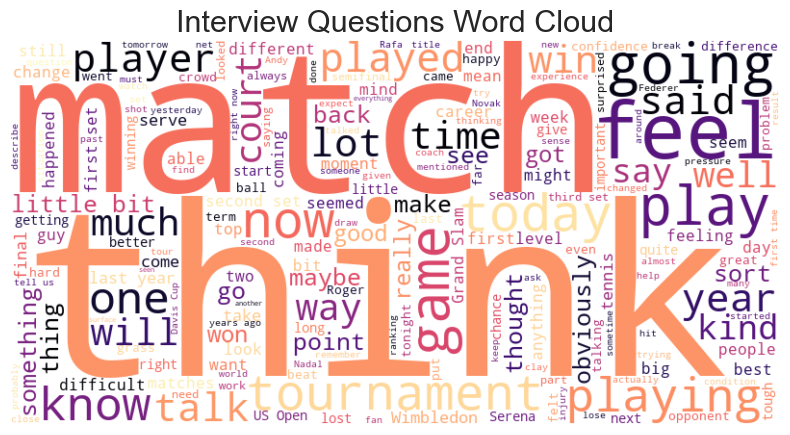

In [ ]:
# All Questions Word Cloud
all_questions_text = ' '.join(questions_df_cleaned['questions'])
all_questions = all_questions_text.split()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(all_questions_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Interview Questions Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Question Data Word Clouds

In [ ]:
# filter into mens and womens data
questions_m_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
questions_f_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']
male_question_text = ' '.join(questions_m_df_cleaned['questions'])
female_question_text = ' '.join(questions_f_df_cleaned['questions'])

# convert male and female words into lists
male_question_words = male_question_text.split()
female_question_words = female_question_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 98110
Female Word Count: 98110
-------------------------------------------------------------------


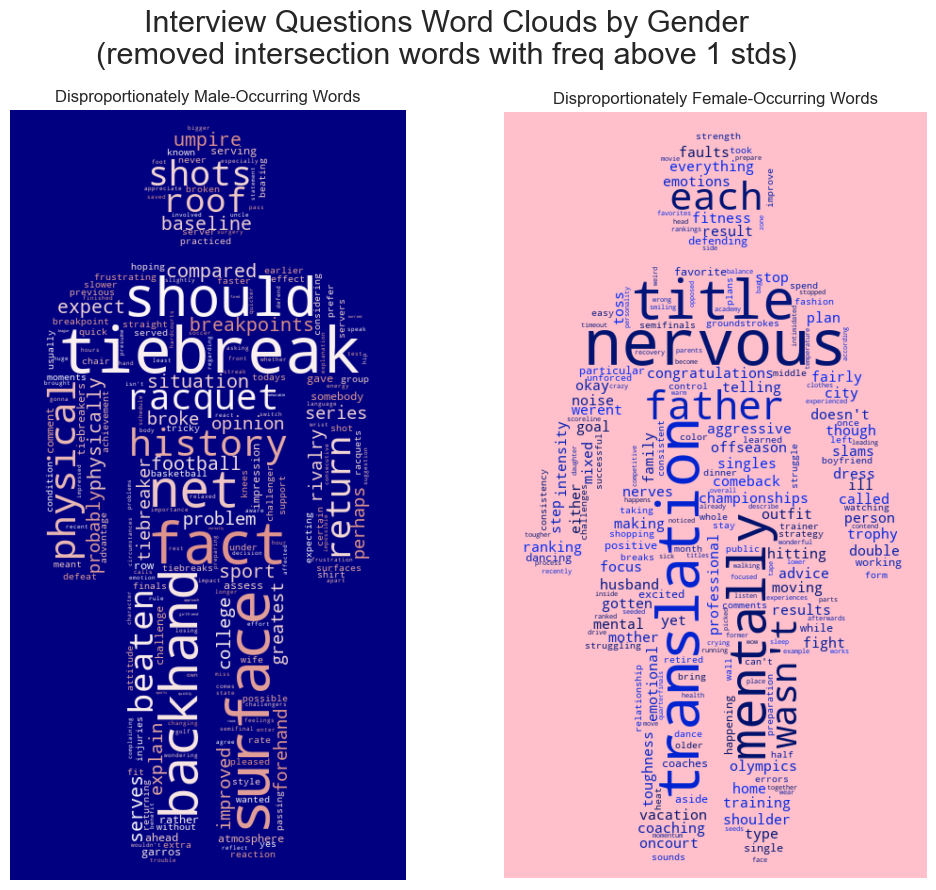

In [ ]:
question_elements_1std, question_counters_1std, question_diff_lists_1std = \
get_diff_words(male_question_words, female_question_words, remove_words, 1, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 36062
Female Word Count: 36062
-------------------------------------------------------------------


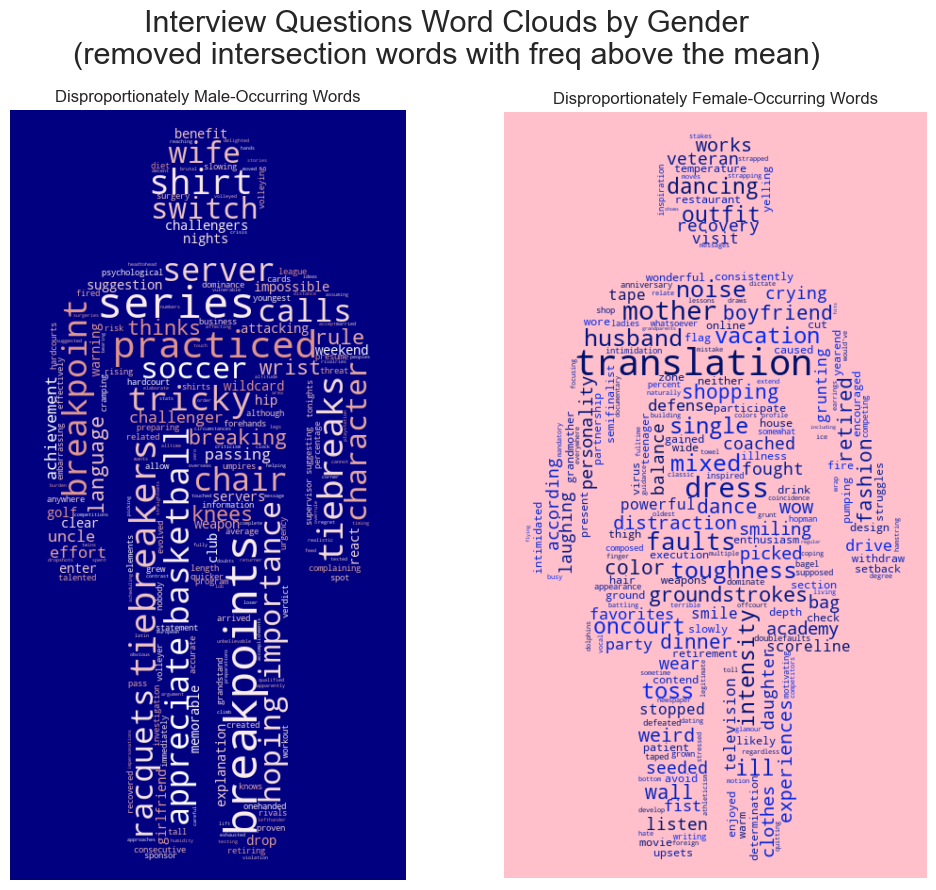

In [ ]:
question_elements_0std, question_counters_0std, question_diff_lists_0std = \
get_diff_words(male_question_words, female_question_words, remove_words, 0, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 3872
Female Word Count: 3872
-------------------------------------------------------------------


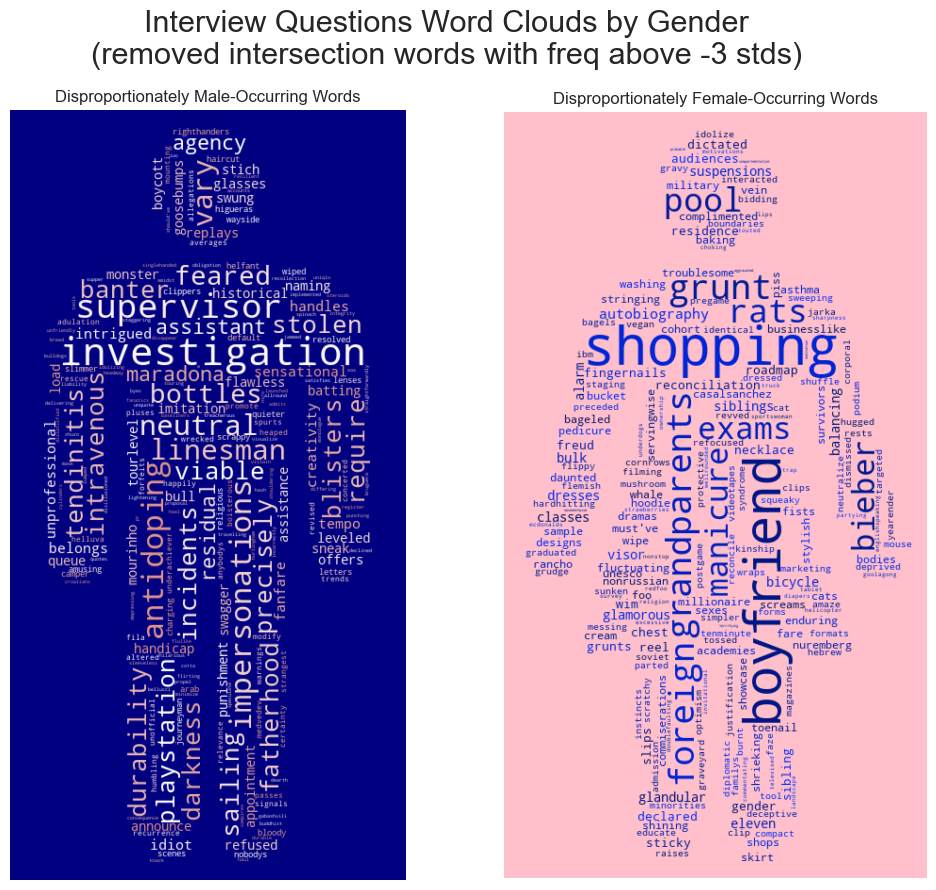

In [ ]:
question_elements_neg_3std, question_counters_neg_3std, question_diff_lists_neg_3std = \
get_diff_words(male_question_words, female_question_words, remove_words, -3, 'Interview Questions')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


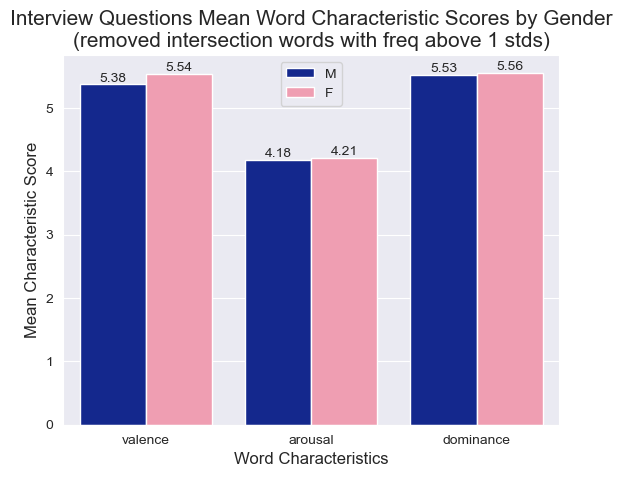

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's questions, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, remove_words,
                                         1, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.69
-------------------------------------------------------------------
Female Percentage of Words Included: 0.7
-------------------------------------------------------------------


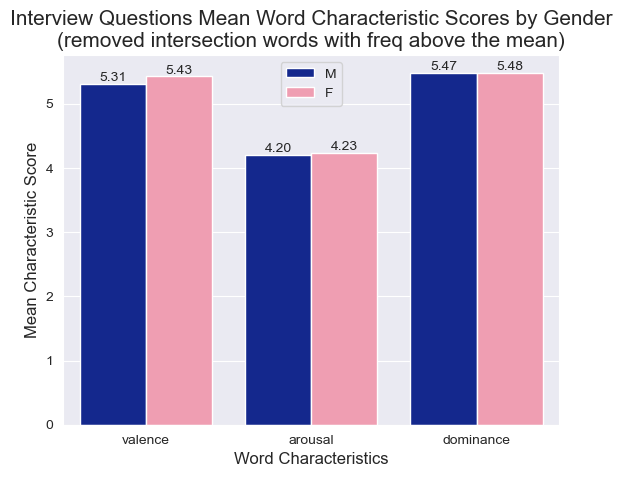

In [ ]:
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, remove_words,
                                         0, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.56
-------------------------------------------------------------------
Female Percentage of Words Included: 0.57
-------------------------------------------------------------------


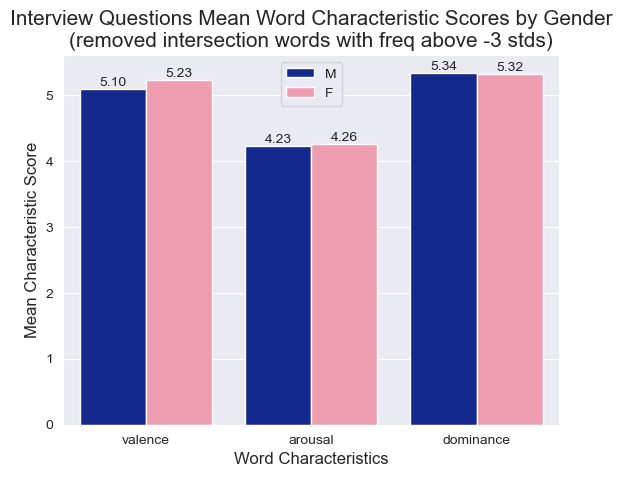

In [ ]:
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, remove_words,
                                         -3, 'Interview Questions')

### Number of Questions Per Ranking For Male and Female Players

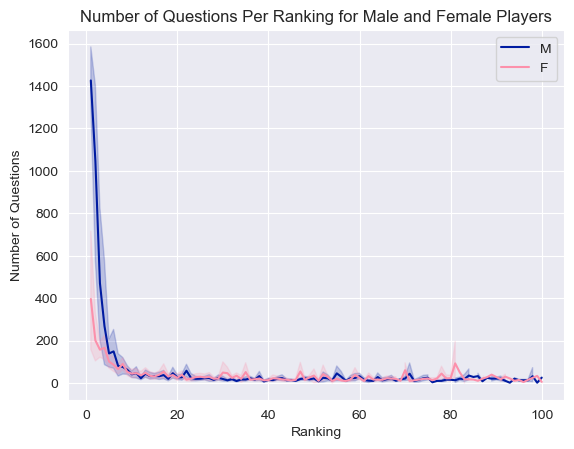

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_100 = question_counts[question_counts['ranking']<=100]
sns.lineplot(data=top_100, x='ranking', y='questions', hue='gender')

# Adding labels and title
plt.xlabel('Ranking')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Per Ranking for Male and Female Players')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Number of Questions for Male and Female Players in the Top 5

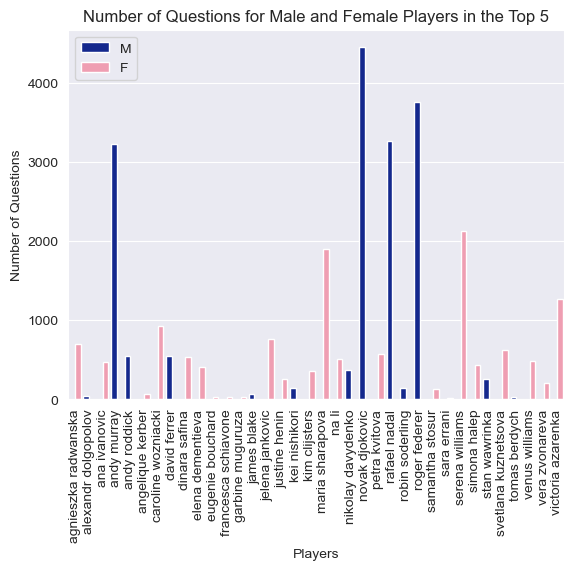

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_5 = question_counts[question_counts['ranking']<=5]
top_5 = top_5.groupby(['player', 'gender'])[['questions']].sum().reset_index()
sns.barplot(data=top_5, x='player', y='questions', hue='gender', hue_order=['M', 'F'])

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

# Adding labels and title
plt.xlabel('Players')
plt.xticks(rotation=90)
plt.ylabel('Number of Questions')
plt.title('Number of Questions for Male and Female Players in the Top 5')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Commentaries Data

The commentary data contains 3962 pieces of live-text play-by-play commentaries, split evenly between men and women singles matches. It is a JSON file with three fields:

	- 'commentary': the actual text from the live updates. It describes the process of the game.
	- 'gender': 'F' indicates the update is from a women's match; 'M' means it is from men's game.
	- 'scoreline': the score when the text update is posted. * indicates the player who is serving at the moment.

While we used Sports Mole's commentaries for our study, ByTheMinute could be another source to gather similar data.



In [ ]:
commentaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3962 entries, 0 to 3961
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   commentary  3962 non-null   object
 1   scoreline   3962 non-null   object
 2   gender      3962 non-null   object
dtypes: object(3)
memory usage: 93.0+ KB


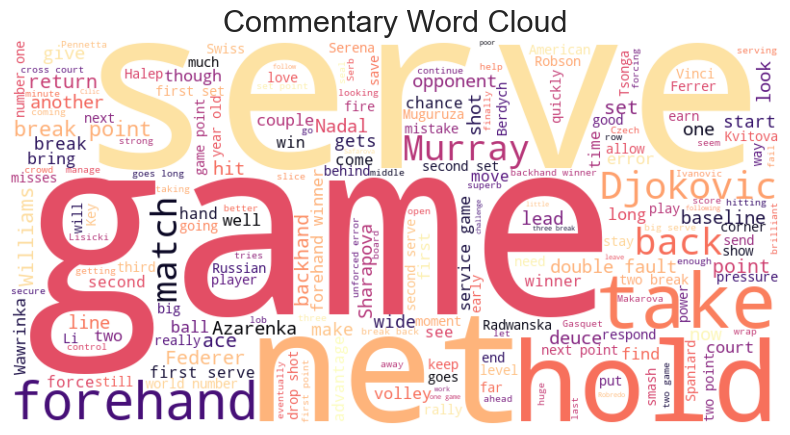

In [ ]:
# All Commentary Word Cloud
all_commentary_text = ' '.join(commentaries_df['commentary'])
all_commentary = all_commentary_text.split()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(all_commentary_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Commentary Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Commentary Data Word Clouds

In [ ]:
# Remove gender specific words, player names, case, and punctuation.

# filter into mens and womens data
commentary_m_df = commentaries_df[commentaries_df['gender'] == 'M']
commentary_f_df = commentaries_df[commentaries_df['gender'] == 'F']
male_commentary_text = ' '.join(commentary_m_df['commentary'])
female_commentary_text = ' '.join(commentary_f_df['commentary'])

# convert male and female words into lists
male_commentary_words = male_commentary_text.split()
female_commentary_words = female_commentary_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 17306
Female Word Count: 17306
-------------------------------------------------------------------


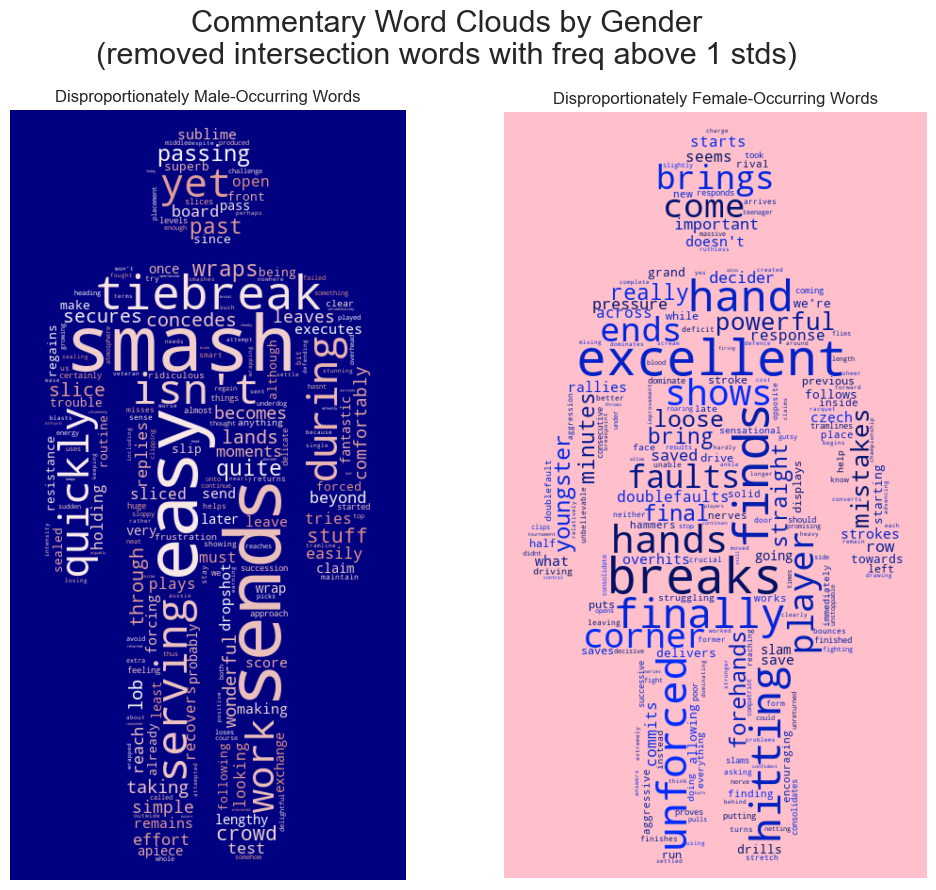

In [ ]:
comm_elements_1std, comm_counters_1std, comm_diff_lists_1std = \
get_diff_words(male_commentary_words, female_commentary_words, remove_words, 1, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 7605
Female Word Count: 7605
-------------------------------------------------------------------


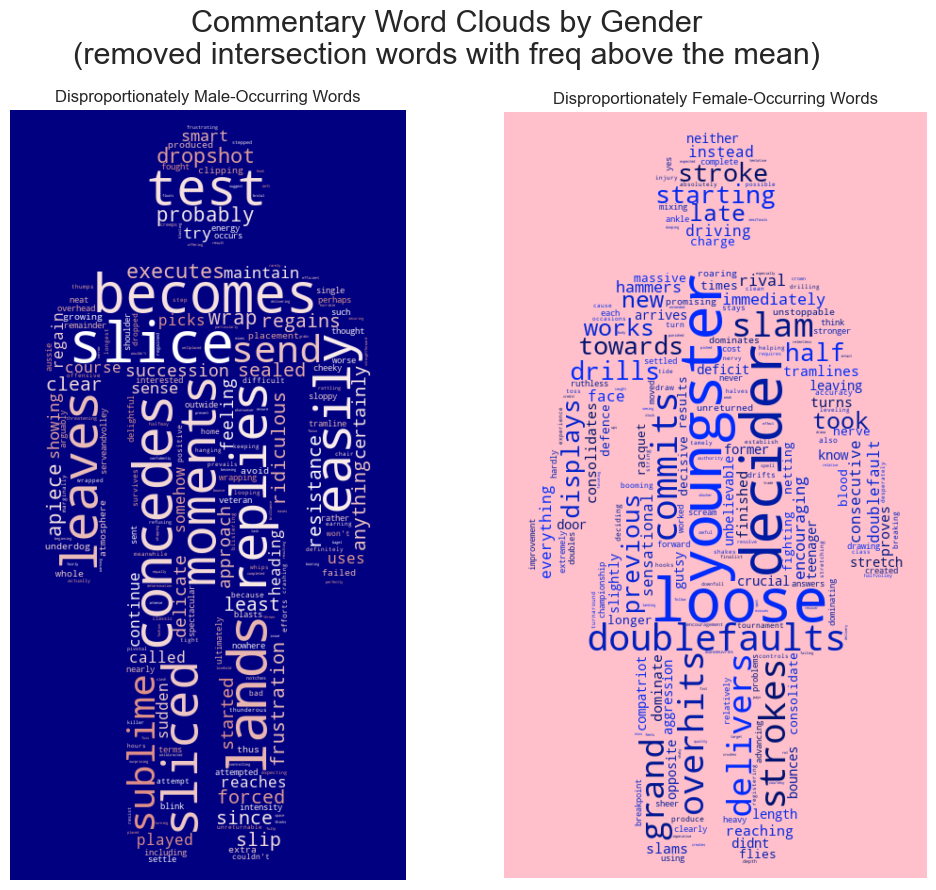

In [ ]:
comm_elements_0std, comm_counters_0std, comm_diff_lists_0std = \
get_diff_words(male_commentary_words, female_commentary_words, remove_words, 0, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 1248
Female Word Count: 1248
-------------------------------------------------------------------


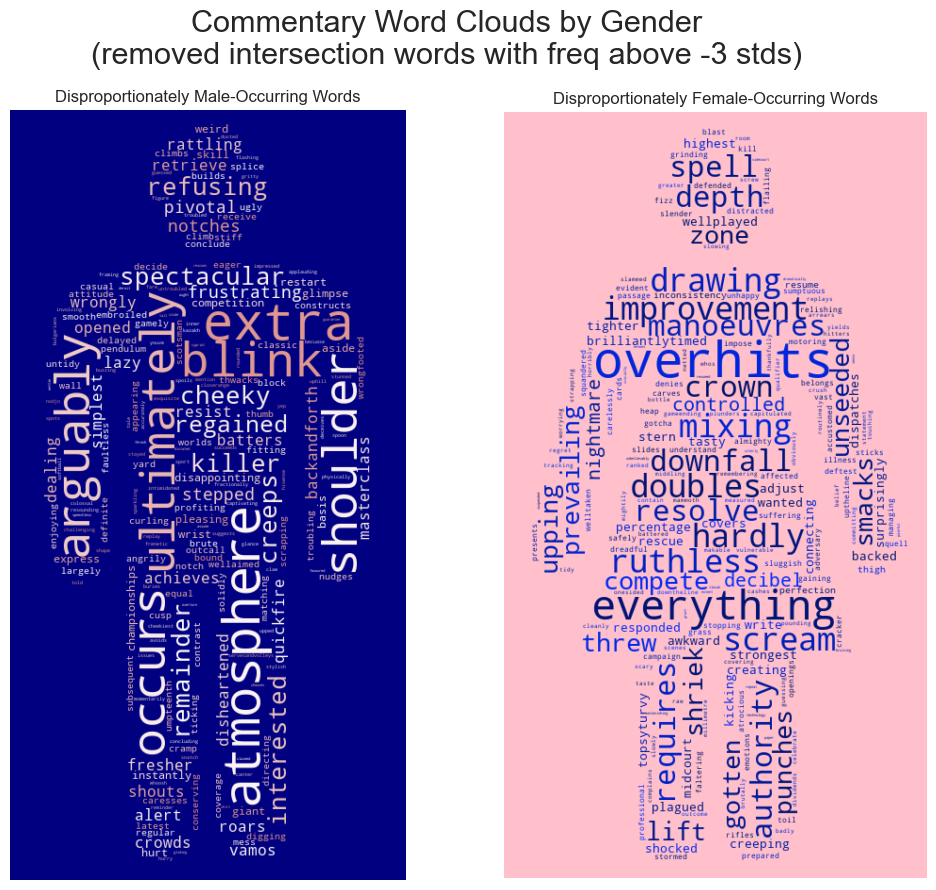

In [ ]:
comm_elements_neg_3std, comm_counters_neg_3std, comm_diff_lists_neg_3std = \
get_diff_words(male_commentary_words, female_commentary_words, remove_words, -3, 'Commentary')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.67
-------------------------------------------------------------------
Female Percentage of Words Included: 0.73
-------------------------------------------------------------------


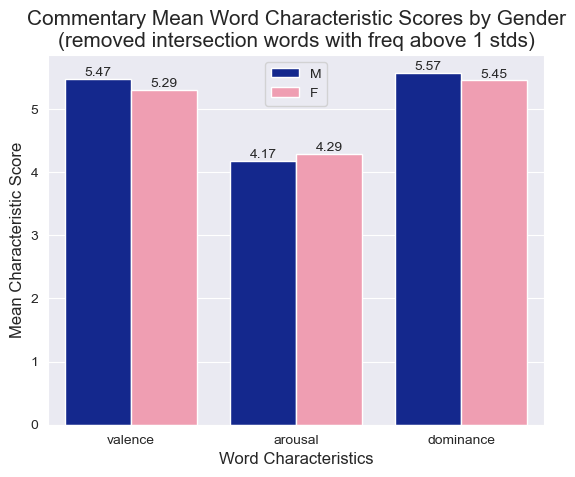

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, remove_words,
                                         1, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.71
-------------------------------------------------------------------


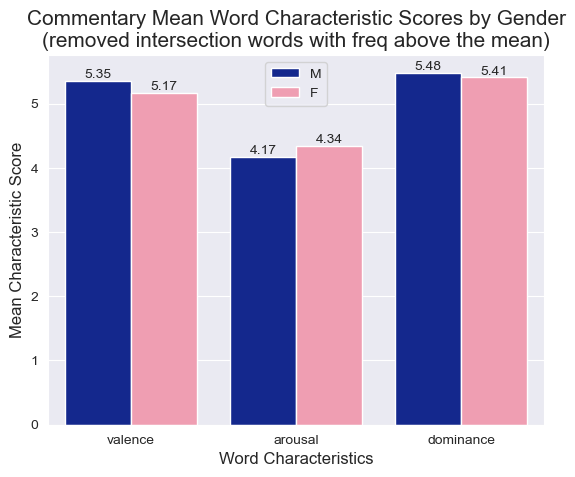

In [ ]:
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, remove_words,
                                         0, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.66
-------------------------------------------------------------------
Female Percentage of Words Included: 0.67
-------------------------------------------------------------------


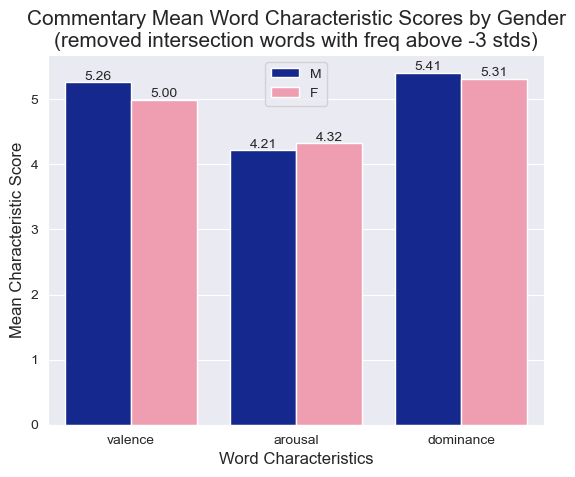

In [ ]:
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, remove_words,
                                         -3, 'Commentary')

### Number of Commentaries for Male and Female Players

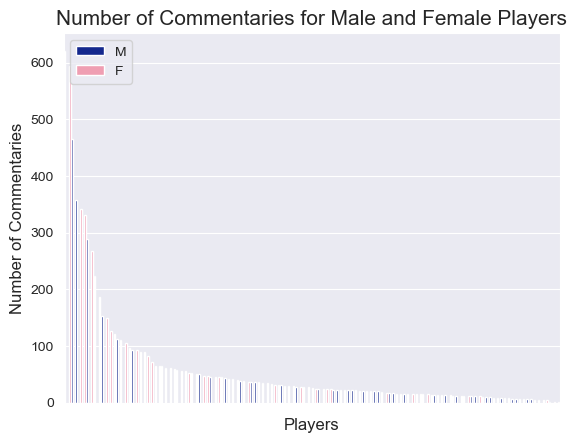

In [ ]:
# combine players into a single column to explore how interviews are divided up

# get two players columns
commentaries_df['player1'] = commentaries_df['scoreline'].apply(lambda x: x.split()[0].replace('*', ''))
commentaries_df['player2'] = commentaries_df['scoreline'].apply(lambda x: x.split()[len(x.split())-1].replace('*', ''))

# concat the dataframe with itself with one combined player column
df1 = commentaries_df
df1 = df1.drop(columns='player2')
df1 = df1.rename(columns={'player1':'player'})
df2 = commentaries_df
df2 = df2.drop(columns='player1')
df2 = df2.rename(columns={'player2':'player'})
frames = [df1, df2]
combined_commentaries_df = pd.concat(frames)
player_comm_feq_df = combined_commentaries_df.groupby(by=["player", "gender"])[['commentary']].count().reset_index()
player_comm_feq_df = player_comm_feq_df.sort_values(by='commentary', ascending=False)

# Commentaries per player by gender

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=player_comm_feq_df, x='player', y='commentary',
                 hue='gender', hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Number of Commentaries for Male and Female Players', fontsize = 15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Players with the Most Commentaries

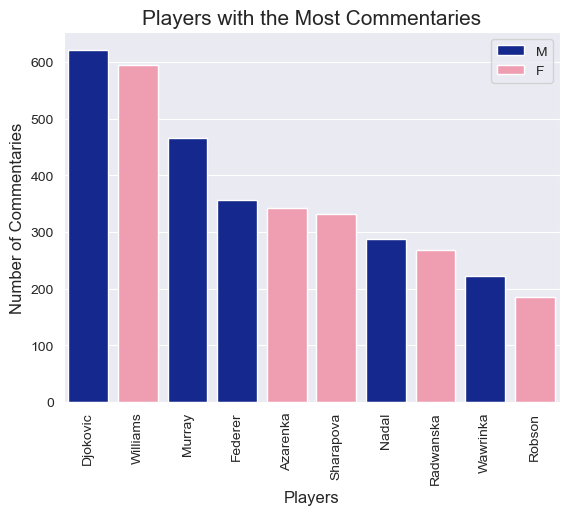

In [ ]:
# The players with the most commentaries (10 most)
top_player_comm_freq_df = player_comm_feq_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=top_player_comm_freq_df, x='player', y='commentary', hue='gender',
                 dodge=False, hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Players with the Most Commentaries', fontsize=15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Comentary Word Count Distribution by Gender

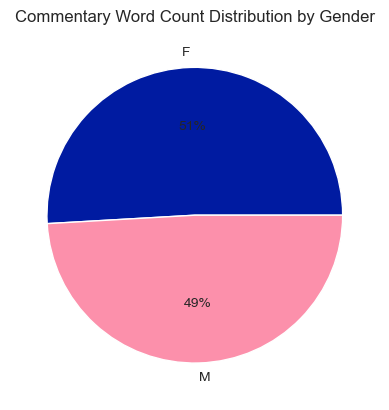

In [ ]:
# explore how the number of words are divded up among male/female commentaries
commentaries_df[['commentary', 'gender']]
commentaries_df['word_length'] = commentaries_df['commentary'].apply(lambda x: len(x))
gender_comm_word_counts_df = commentaries_df.groupby(by=['gender'])[['word_length']].sum().reset_index()

# plotting data on chart

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

plt.pie(data=gender_comm_word_counts_df, x= 'word_length', labels='gender',
        autopct='%.0f%%')

plt.title('Commentary Word Count Distribution by Gender')

# displaying chart
plt.show()

## Transcripts Data

The dataset provide the full transcript (i.e. both questions and player responses), in the format of a JSON file:

	>>> import json
	>>> with open("transcripts_matchinfo.json", "r") as f:
	...		interviews = json.load(f)

	The following is an example for one transcript, with each field explained:

	>>> interview = interviews['0']
	0: {
		'QandA': ...  
			# Interview transcripts in the format of a list of question answer pairs.   
		'date': '2015-06-21',  # date the match is played
		'gender': 'M', # 'F' indicates women's singles match, 'M' indicates men's.
		'opponent': 'Kevin Anderson', # opponent in the match
			(available only if the opponent has at least one interview recorded in our dataset.)
  		'player': 'Andy Murray', # player being interviewed
  		'ranking': 3, # ranking of the player
  		'result': 1,  # 1 indicates the player being interviewed has won the match; 0 otherwise.
    		'stage': 'The Final', # stage of the tournament
  		'tournament': 'AEGON CHAMPIONSHIPS' # tournament name
		'tournament_type': 'ATP500', # type of the tournament, indicating tournament prestige.
	}

Note that:

- These questions and answers are transcribed exactly the way the journalists and the players put it; they are not further edited for grammatical correctness. There are, although relatively rarely, questions that are marked as (Off microphone.), (Indiscernible) or even (Translated from X) where X is a language other than English.
- Information about which journalist asked which question is not available.
- This transcript data does not contain all singles press conference transcripts available at ASAP sports as we only included transcripts that we could find corresponding match information for. In addition, since transcripts data and match results are matched by date and player last name, and we did not manually check for every match, it is possible to have a few matching errors.



In [ ]:
transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QandA            6467 non-null   object        
 1   ranking          6466 non-null   float64       
 2   tournament_type  6467 non-null   object        
 3   gender           6467 non-null   object        
 4   tournament       6467 non-null   object        
 5   player           6467 non-null   object        
 6   result           6467 non-null   int64         
 7   date             6467 non-null   datetime64[ns]
 8   stage            6467 non-null   object        
 9   opponent         6467 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 555.8+ KB


### Interview Data by Tournament

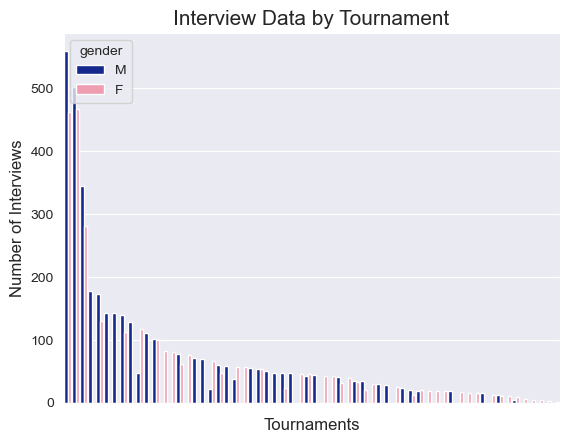

In [ ]:
tournaments_df = transcripts_df.groupby(by=['tournament', 'gender'])[['QandA']].count().reset_index()
tournaments_df = tournaments_df.sort_values(by='QandA', ascending=False)

# Tournament Frequencies
g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA', hue='gender',
                 hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament', fontsize = 15)

# Display the plot
plt.show()

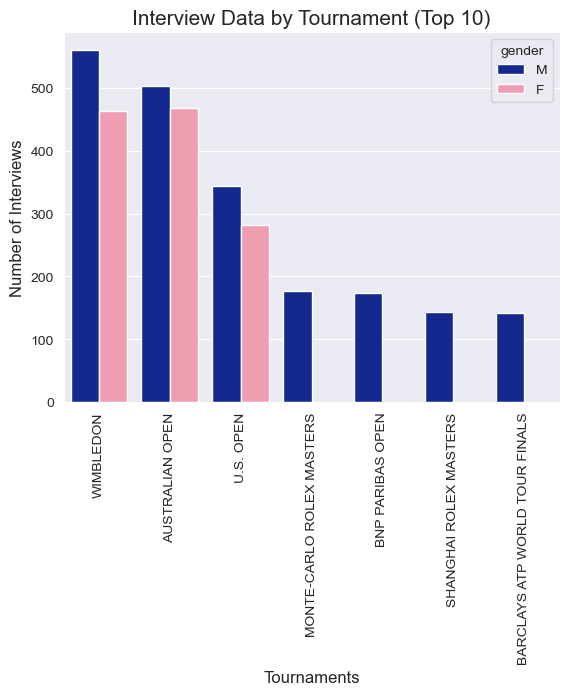

In [ ]:
# The players with the most commentaries (10 most)
tournaments_df = tournaments_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA',
                 hue='gender', hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament (Top 10)', fontsize = 15)

# Display the plot
plt.show()

### Get answers in terms of gender as two lists of words

In [ ]:
male_transcripts_df = transcripts_df[transcripts_df['gender'] == 'M']
female_transcripts_df = transcripts_df[transcripts_df['gender'] == 'F']

male_answers = []
for interview in male_transcripts_df['QandA'].to_list():
  for qna in interview:
    male_answers.append(qna[1])

female_answers = []
for interview in female_transcripts_df['QandA'].to_list():
  for qna in interview:
    female_answers.append(qna[1])

split_words = [words.split() for words in male_answers]
male_answers_words = [word for words in split_words for word in words]

split_words = [words.split() for words in female_answers]
female_answers_words = [word for words in split_words for word in words]

male_answers_text = ' '.join(male_answers_words)
female_answers_text = ' '.join(female_answers_words)
all_answers_text = male_answers_text + ' ' + female_answers_text

### Interview Answers Word Clouds by Gender

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.20889261744966
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5476758931608
-------------------------------------------------------------------
Male Word Count: 241453
Female Word Count: 241453
-------------------------------------------------------------------


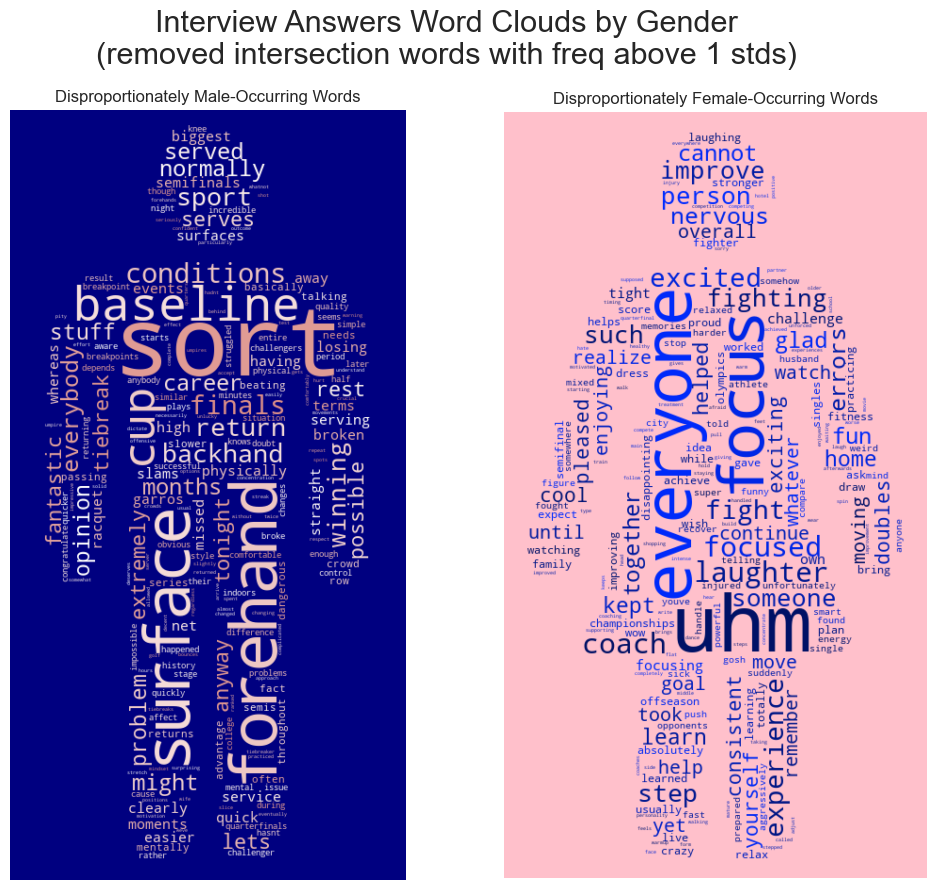

In [ ]:
ans_elements_1std, ans_counters_1std, ans_diff_lists_1std = \
get_diff_words(male_answers_words, female_answers_words, remove_words, 1, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.20889261744966
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5476758931608
-------------------------------------------------------------------
Male Word Count: 70178
Female Word Count: 70178
-------------------------------------------------------------------


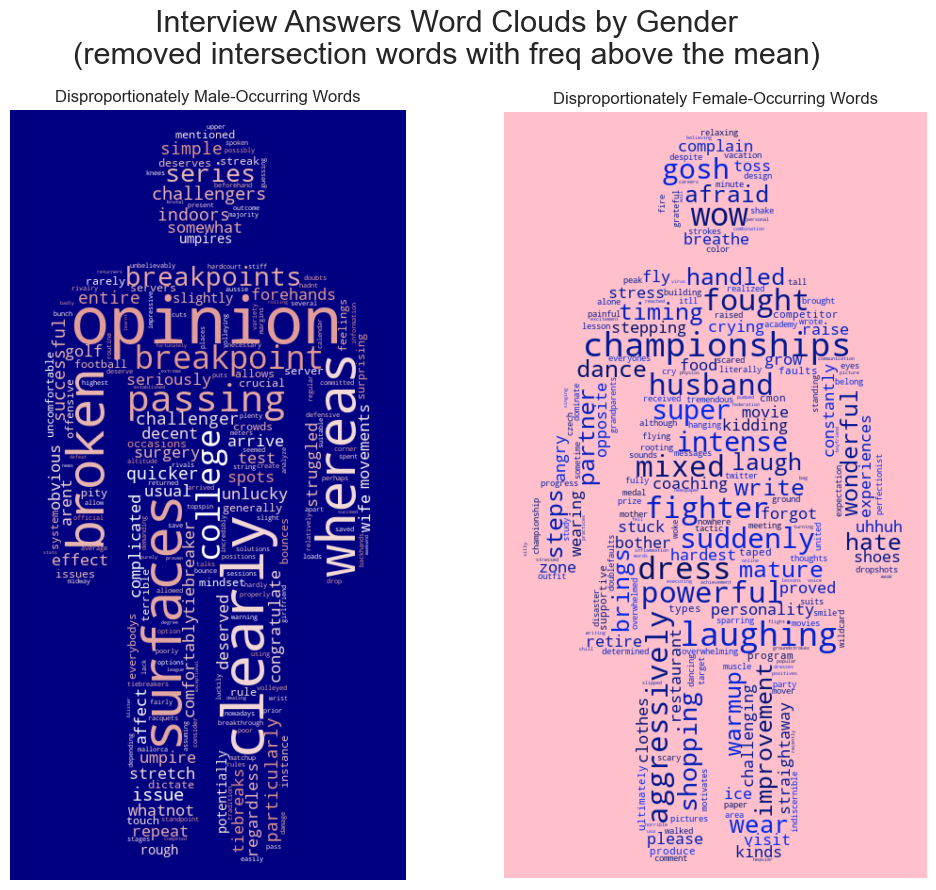

In [ ]:
ans_elements_0std, ans_counters_0std, ans_diff_lists_0std = \
get_diff_words(male_answers_words, female_answers_words, remove_words, 0, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.20889261744966
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5476758931608
-------------------------------------------------------------------
Male Word Count: 4011
Female Word Count: 4011
-------------------------------------------------------------------


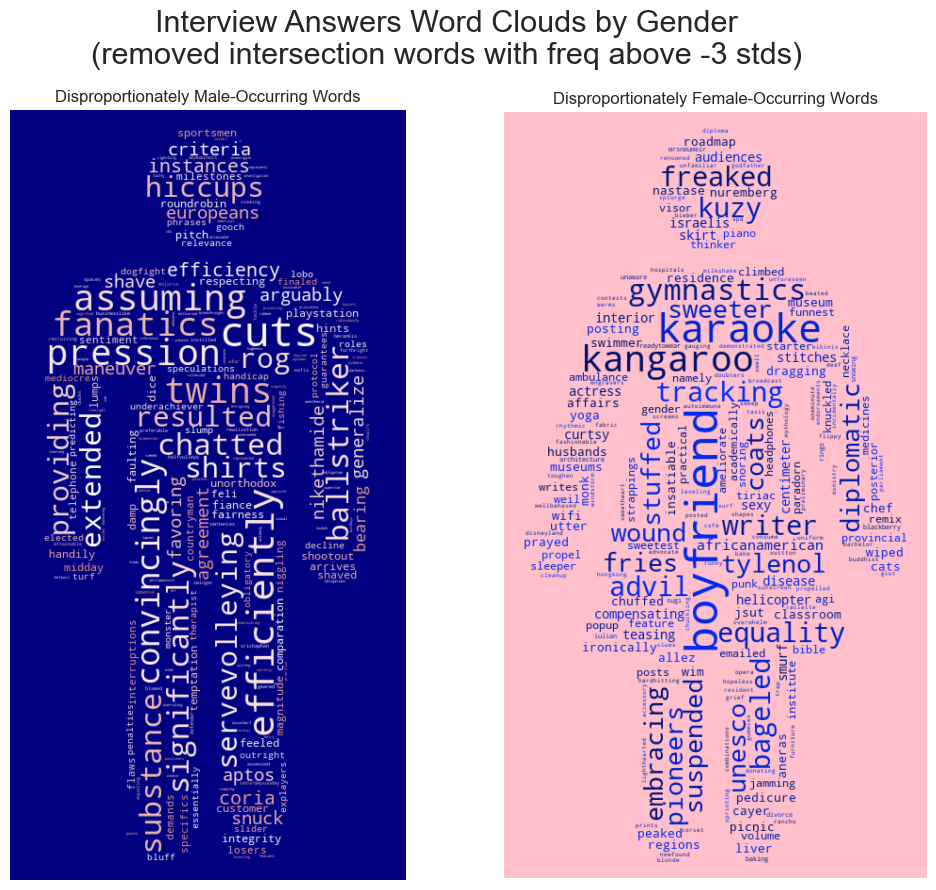

In [ ]:
ans_elements_neg_3std, ans_counters_neg_3std, ans_diff_lists_neg_3std = \
get_diff_words(male_answers_words, female_answers_words, remove_words, -3, 'Interview Answers')

### Interview Answers Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.69
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


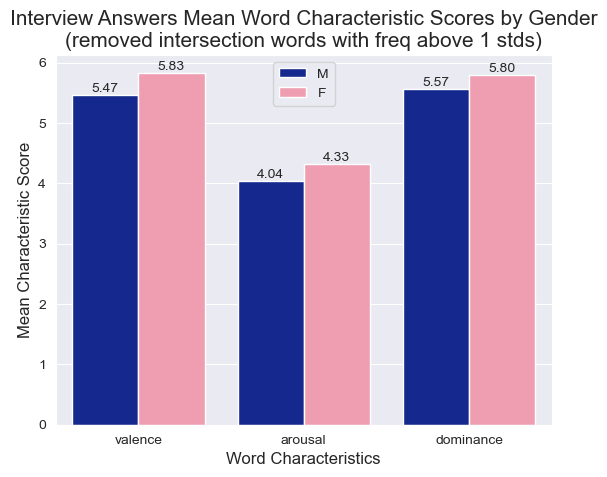

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, remove_words,
                                         1, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.72
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


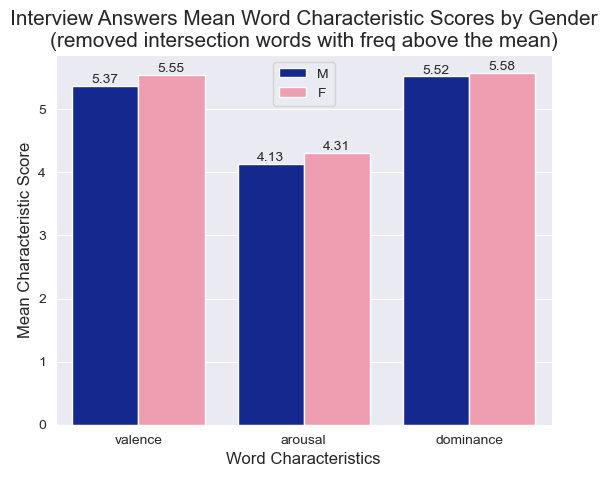

In [ ]:
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, remove_words,
                                         0, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.55
-------------------------------------------------------------------
Female Percentage of Words Included: 0.53
-------------------------------------------------------------------


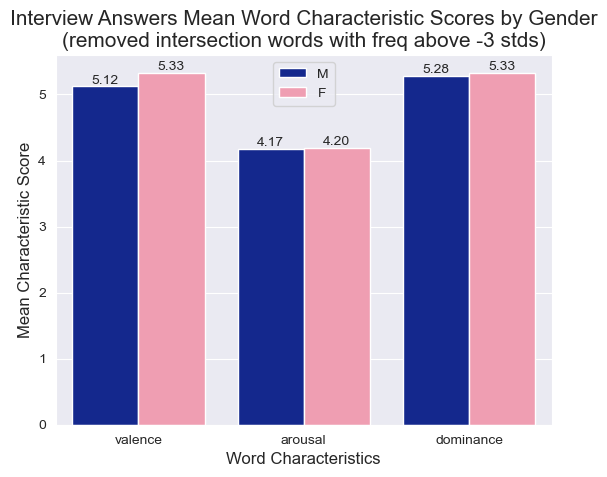

In [ ]:
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, remove_words,
                                         -3, 'Interview Answers')

## Establishing Baselines

### Simple Baseline: Similar top words for male & female tennis players.

Our simple baseline will be a similarity score between the top words for male & female tennis players. To calculate this, we will extract the 30 most common words for both groups and then compare the number of those top 30 words that are related to tennis. This is a similar simple baseline to the one established early in the paper we aim to recreate.

In [ ]:
import re
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
import nltk

# Download the stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def get_top_30_sorted_tuples(diff_list):
    # Sort the list of tuples in descending order based on the second element (count)
    sorted_list = sorted(diff_list, key=lambda x: x[1], reverse=True)

    # Return the first 30 elements
    top_30 = sorted_list[:30]

    return top_30

Use chatGPT to first develop a list of tennis-related words. Then, manually add to this list through research from a dictionary etc. The Paper 0 methodology involved actually using the commentary data to determine tennis-related words. In this simple baseline, we will use this list as our determinant of tennis-related words.

ChatGPT prompt:

```
# You are a tennis commentator for the world's most elite athletes.
#We are building a language model to understand tennis commentary better.
#Give me a list of all the words related to tennis that we should consider
#when building a model to detect tennis-related words in commentary and tennis player post-match, pre-match interviews.
```



In [ ]:
tennis_related_words = [
    # Player-Specific Terms
    "player", "singles", "doubles", "opponent", "contender", "challenger", "world", "no", "1", "secures", "hands", "mistakes", "fault", "faults"

    # Match and Game Terms
    "match", "game", "set", "point", "tiebreak", "break", "serve", "volley", "rally", "net", "baseline", "advantage", "deuce", "game", "set", "match", "breaks", "hitting"

    # Tournament and Event Terms
    "grand", "slam", "atp", "wta", "major", "championship", "slam", "masters", "davis", "cup", "fed", "finals", "qualifier", "wildcard",

    # Court and Surface Terms
    "court", "surface", "clay", "grass", "hardcourt", "indoor", "outdoor", "plexicushion", "decoturf", "lands", "sends"

    # Skill and Technique Terms
    "forehand", "forehands", "backhand", "serve", "serving", "volley", "slice", "topspin", "drop", "lob", "smash", "approach", "passing", "spin", "power", "lands", "smash"

    # Equipment and Gear Terms
    "racket", "strings", "grip", "tennis", "ball", "racquet", "bag", "court", "shoes", "apparel", "gear", "kit",

    # Officials and Rules Terms
    "umpire", "chair", "umpire", "line", "judge", "hawk-eye", "challenge", "code", "violation", "let", "net", "cord", "foot", "fault", "double", "fault",

    # Ranking and Seeding Terms
    "ranking", "seed", "world", "number", "one", "top", "seed", "wildcard", "challenger", "qualifier", "round-robin", "concedes"

    # Performance and Strategy Terms
    "ace", "double", "fault", "strategy", "tactics", "mental", "toughness", "fitness", "endurance", "stamina", "speed", "precision", "decider",

    # Achievements and Records Terms
    "grand", "slam", "title", "career", "slam", "golden", "slam", "record", "milestone", "hall", "fame", "winning", "streak", "crowd",

    # Interview and Commentary Terms
    "interview", "commentator", "recap", "prediction", "post-match", "pre-match"
]

# Test print to verify the list
print(tennis_related_words)


['player', 'singles', 'doubles', 'opponent', 'contender', 'challenger', 'world', 'no', '1', 'secures', 'hands', 'mistakes', 'fault', 'faultsmatch', 'game', 'set', 'point', 'tiebreak', 'break', 'serve', 'volley', 'rally', 'net', 'baseline', 'advantage', 'deuce', 'game', 'set', 'match', 'breaks', 'hittinggrand', 'slam', 'atp', 'wta', 'major', 'championship', 'slam', 'masters', 'davis', 'cup', 'fed', 'finals', 'qualifier', 'wildcard', 'court', 'surface', 'clay', 'grass', 'hardcourt', 'indoor', 'outdoor', 'plexicushion', 'decoturf', 'lands', 'sendsforehand', 'forehands', 'backhand', 'serve', 'serving', 'volley', 'slice', 'topspin', 'drop', 'lob', 'smash', 'approach', 'passing', 'spin', 'power', 'lands', 'smashracket', 'strings', 'grip', 'tennis', 'ball', 'racquet', 'bag', 'court', 'shoes', 'apparel', 'gear', 'kit', 'umpire', 'chair', 'umpire', 'line', 'judge', 'hawk-eye', 'challenge', 'code', 'violation', 'let', 'net', 'cord', 'foot', 'fault', 'double', 'fault', 'ranking', 'seed', 'world',

In [ ]:
top_30_female = get_top_30_sorted_tuples(comm_diff_lists_1std[1].most_common())

In [ ]:
top_30_male = get_top_30_sorted_tuples(comm_diff_lists_1std[0].most_common())

In [ ]:
def calculate_tennis_simple_percentage(diff_list, tennis_related_words):
    # Convert tennis_related_words to a set for faster membership testing
    tennis_related_set = set(tennis_related_words)

    # Calculate the total number of words in diff_list
    total_words = sum(count for _, count in diff_list)

    # Calculate the number of tennis-related words in diff_list
    tennis_related_count = sum(count for word, count in diff_list if word.lower() in tennis_related_set)

    # Calculate the percentage of tennis-related words
    percentage_tennis_related = (tennis_related_count / total_words) * 100 if total_words > 0 else 0

    return percentage_tennis_related

In [ ]:
male_question_perc_tennis_top30 = calculate_tennis_simple_percentage(top_30_male, tennis_related_words)
male_question_perc_tennis_top30

32.475884244372985

In [ ]:
female_question_perc_tennis_top_30 = calculate_tennis_simple_percentage(top_30_female, tennis_related_words)
female_question_perc_tennis_top_30

21.279373368146214

This serves as a simple baseline. We see that men have more words than women that are directly tennis related when looking at the top 30 ngrams for questions asked to both women and men.

### Complex Baseline: BERT classification

This baseline is the baseline ultimately used by Paper 0; it is a calculation of perplexity where low perplexity for a question indicates a lower bias.

# Language Models

## Tokenize Commentary Data

In [ ]:
# all commentary tokens
tok_all_commentary = [word_tokenize(sent) for sent in sent_tokenize(all_commentary_text.lower())]

# get all male commentary tokens
tok_male_commentary = [word_tokenize(sent) for sent in sent_tokenize(male_commentary_text.lower())]

# get all female commentary tokens
tok_female_commentary = [word_tokenize(sent) for sent in sent_tokenize(female_commentary_text.lower())]

# get all questions tokens
tok_all_questions = [word_tokenize(sent) for sent in sent_tokenize(all_questions_text.lower())]

# male questions
male_q_df = questions_df[questions_df['gender'] == 'M']
male_q_df = male_q_df.explode(column='questions').reset_index().drop(columns=['index'])
male_q_df = male_q_df.rename(columns={'questions':'text'})

# get all male question tokens
male_q_text = male_q_df['text'].to_list()
tok_male_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(male_q_text))]

# get top 10 ranked male question tokens
male_t10_q_df = male_q_df[male_q_df['ranking'] <= 10]
male_t10_q_text = male_t10_q_df['text'].to_list()
tok_male_t10_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(male_t10_q_text))]

# get lower ranked male question tokens
male_low_rank_q_df = male_q_df[male_q_df['ranking'] > 10]
male_low_rank_q_text = male_low_rank_q_df['text'].to_list()
tok_male_low_rank_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(male_low_rank_q_text))]

# female questions
female_q_df = questions_df[questions_df['gender'] == 'F']
female_q_df = female_q_df.explode(column='questions').reset_index().drop(columns=['index'])
female_q_df = female_q_df.rename(columns={'questions':'text'})

# get all female question tokens
female_q_text = female_q_df['text'].to_list()
tok_female_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(female_q_text))]

# get top 10 ranked female question tokens
female_t10_q_df = female_q_df[female_q_df['ranking'] <= 10]
female_t10_q_text = female_t10_q_df['text'].to_list()
tok_female_t10_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(female_t10_q_text))]

# get lower ranked female question tokens
female_low_rank_q_df = female_q_df[female_q_df['ranking'] > 10]
female_low_rank_q_text = female_low_rank_q_df['text'].to_list()
tok_female_low_rank_q = [word_tokenize(q.lower()) for q in sent_tokenize(' '.join(female_low_rank_q_text))]

In [ ]:
# # all answers (this cell takes about an hour to run, but I saved the results and we imported them at the start).

# tok_all_answers_text = [word_tokenize(word) for word in sent_tokenize(all_answers_text)]
# tok_all_text = tok_all_answers_text + tok_all_commentary_text + tok_all_questions_text

# # save all tokenized text to file (so that you don't have to run that long one again)
# pd.DataFrame(tok_all_text).to_csv("tok_all_text.csv",index=False)

## Bi-gram Model Trained on All Commentary Data

### Construct Bigrams

Get bigrams for questions, where all questions are concatenated

In [ ]:
bigrams_all_commentary = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_all_commentary] for gram in sent]
bigrams_male_commentary = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_male_commentary] for gram in sent]
bigrams_female_commentary = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_female_commentary] for gram in sent]

bigrams_male_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_male_q] for gram in sent]
bigrams_female_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_female_q] for gram in sent]

bigrams_male_t10_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_male_t10_q] for gram in sent]
bigrams_male_low_rank_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_male_low_rank_q] for gram in sent]

bigrams_female_t10_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_female_t10_q] for gram in sent]
bigrams_female_low_rank_q = [gram for sent in [list(bigrams(pad_both_ends(sent, n=2))) for sent in tok_female_low_rank_q] for gram in sent]

Get bigrams for questions, where each question is a list index

In [ ]:
male_q_lst = male_q_df['text'].values.tolist()
bigram_male_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in male_q_lst]

female_q_lst = female_q_df['text'].values.tolist()
bigram_female_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in female_q_lst]

In [ ]:
bigram_male_t10_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in male_t10_q_text]
bigram_male_low_rank_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in male_low_rank_q_text]

bigram_female_t10_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in female_t10_q_text]
bigram_female_low_rank_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in female_low_rank_q_text]

### Construct Models

In [ ]:
vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary)[1], unk_cutoff=2)
mle_model2 = MLE(2, vocabulary = vocab)
mle_model2.fit(padded_everygram_pipeline(2, tok_all_commentary)[0], vocab)
print(len(mle_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary)[1], unk_cutoff=2)
adi_model2 = AbsoluteDiscountingInterpolated(2, vocabulary = vocab)
adi_model2.fit(padded_everygram_pipeline(2, tok_all_commentary)[0], vocab)
print(len(adi_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary)[1], unk_cutoff=2)
lap_model2 = Laplace(2, vocabulary = vocab)
lap_model2.fit(padded_everygram_pipeline(2, tok_all_commentary)[0], vocab)
print(len(lap_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary)[1], unk_cutoff=2)
kni_model2 = KneserNeyInterpolated(2, vocabulary = vocab)
kni_model2.fit(padded_everygram_pipeline(2, tok_all_commentary)[0], vocab)
print(len(kni_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary)[1], unk_cutoff=2)
sb_model2 = StupidBackoff(order=2, vocabulary = vocab)
sb_model2.fit(padded_everygram_pipeline(2, tok_all_commentary)[0], vocab)
print(len(sb_model2.vocab))

3232
3232
3232
3232
3232


Get the commentary perplexity

In [ ]:
mle_bigrams_all_commentary = mle_model2.perplexity(bigrams_all_commentary)
mle_bigrams_all_commentary

26.635324983425694

In [ ]:
adi_bigrams_all_commentary = adi_model2.perplexity(bigrams_all_commentary)
adi_bigrams_all_commentary

32.59688971465524

In [ ]:
lap_bigrams_all_commentary = lap_model2.perplexity(bigrams_all_commentary)
lap_bigrams_all_commentary

162.51241335817056

In [ ]:
sb_bigrams_all_commentary = sb_model2.perplexity(bigrams_all_commentary)
sb_bigrams_all_commentary

26.635324983425694

In [ ]:
kni_bigrams_all_commentary = kni_model2.perplexity(bigrams_all_commentary)
kni_bigrams_all_commentary

27.12686500203053

### Male Perplexities

#### All Question Perplexity

In [ ]:
mle_bigrams_male_q = mle_model2.perplexity(bigrams_male_q)
mle_bigrams_male_q

inf

In [ ]:
adi_bigrams_male_q = adi_model2.perplexity(bigrams_male_q)
adi_bigrams_male_q

278.16339124733594

In [ ]:
lap_bigrams_male_q = lap_model2.perplexity(bigrams_male_q)
lap_bigrams_male_q

608.0284176923267

In [ ]:
sb_bigrams_male_q = sb_model2.perplexity(bigrams_male_q)
sb_bigrams_male_q

218.01354200885996

In [ ]:
kni_bigrams_male_q = kni_model2.perplexity(bigrams_male_q)
kni_bigrams_male_q

411.25608818307694

#### Mean Question Perplexity

In [ ]:
mle_bigram_male_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_male_q_lst])
mle_bigram_male_q_lst

inf

In [ ]:
adi_bigram_male_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_male_q_lst])
adi_bigram_male_q_lst

375.7757456360416

In [ ]:
lap_bigram_male_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_male_q_lst])
lap_bigram_male_q_lst

685.3608810513621

In [ ]:
sb_bigram_male_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_male_q_lst])
sb_bigram_male_q_lst

286.8829117305945

In [ ]:
kni_bigram_male_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_male_q_lst])
kni_bigram_male_q_lst

732.5201272598467

#### Ranking Split All Question Perplexity

##### Top 10

In [ ]:
mle_bigrams_male_t10_q = mle_model2.perplexity(bigrams_male_t10_q)
mle_bigrams_male_t10_q

inf

In [ ]:
adi_bigrams_male_t10_q = adi_model2.perplexity(bigrams_male_t10_q)
adi_bigrams_male_t10_q

276.8417542326294

In [ ]:
lap_bigrams_male_t10_q = lap_model2.perplexity(bigrams_male_t10_q)
lap_bigrams_male_t10_q

606.3830740704503

In [ ]:
sb_bigrams_male_t10_q = sb_model2.perplexity(bigrams_male_t10_q)
sb_bigrams_male_t10_q

217.18173071480416

In [ ]:
kni_bigrams_male_t10_q = kni_model2.perplexity(bigrams_male_t10_q)
kni_bigrams_male_t10_q

408.71615160943236

##### Not Top 10

In [ ]:
mle_bigrams_male_low_rank_q = mle_model2.perplexity(bigrams_male_low_rank_q)
mle_bigrams_male_low_rank_q

inf

In [ ]:
adi_bigrams_male_low_rank_q = adi_model2.perplexity(bigrams_male_low_rank_q)
adi_bigrams_male_low_rank_q

279.9440663002258

In [ ]:
lap_bigrams_male_low_rank_q = lap_model2.perplexity(bigrams_male_low_rank_q)
lap_bigrams_male_low_rank_q

610.2379477884016

In [ ]:
sb_bigrams_male_low_rank_q = sb_model2.perplexity(bigrams_male_low_rank_q)
sb_bigrams_male_low_rank_q

219.13141201416127

In [ ]:
kni_bigrams_male_low_rank_q = kni_model2.perplexity(bigrams_male_low_rank_q)
kni_bigrams_male_low_rank_q

414.67045415243103

#### Ranking Split Mean Question Perplexity

##### Top 10

In [ ]:
mle_bigram_male_t10_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_male_t10_q_lst])
mle_bigram_male_t10_q_lst

inf

In [ ]:
adi_bigram_male_t10_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_male_t10_q_lst])
adi_bigram_male_t10_q_lst

368.66300143108725

In [ ]:
lap_bigram_male_t10_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_male_t10_q_lst])
lap_bigram_male_t10_q_lst

679.5310228264321

In [ ]:
sb_bigram_male_t10_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_male_t10_q_lst])
sb_bigram_male_t10_q_lst

281.44455391760675

In [ ]:
kni_bigram_male_t10_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_male_t10_q_lst])
kni_bigram_male_t10_q_lst

725.4000146498702

##### Not Top 10

In [ ]:
mle_bigram_male_low_rank_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_male_low_rank_q_lst])
mle_bigram_male_low_rank_q_lst

inf

In [ ]:
adi_bigram_male_low_rank_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_male_low_rank_q_lst])
adi_bigram_male_low_rank_q_lst

383.8113862290947

In [ ]:
lap_bigram_male_low_rank_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_male_low_rank_q_lst])
lap_bigram_male_low_rank_q_lst

691.9471779930346

In [ ]:
sb_bigram_male_low_rank_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_male_low_rank_q_lst])
sb_bigram_male_low_rank_q_lst

293.02691010061216

In [ ]:
kni_bigram_male_low_rank_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_male_low_rank_q_lst])
kni_bigram_male_low_rank_q_lst

740.5640923269419

### Female Perplexities

#### All Question Perplexity

In [ ]:
mle_bigrams_female_q = mle_model2.perplexity(bigrams_female_q)
mle_bigrams_female_q

inf

In [ ]:
adi_bigrams_female_q = adi_model2.perplexity(bigrams_female_q)
adi_bigrams_female_q

279.4699845615158

In [ ]:
lap_bigrams_female_q = lap_model2.perplexity(bigrams_female_q)
lap_bigrams_female_q

615.1475885728072

In [ ]:
sb_bigrams_female_q = sb_model2.perplexity(bigrams_female_q)
sb_bigrams_female_q

217.9390314609129

In [ ]:
kni_bigrams_female_q = kni_model2.perplexity(bigrams_female_q)
kni_bigrams_female_q

412.17460849600957

#### Mean Question Perplexity

In [ ]:
mle_bigram_female_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_female_q_lst])
mle_bigram_female_q_lst

inf

In [ ]:
adi_bigram_female_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_female_q_lst])
adi_bigram_female_q_lst

377.6187264561777

In [ ]:
lap_bigram_female_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_female_q_lst])
lap_bigram_female_q_lst

689.2090136873919

In [ ]:
sb_bigram_female_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_female_q_lst])
sb_bigram_female_q_lst

287.1515981996536

In [ ]:
kni_bigram_female_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_female_q_lst])
kni_bigram_female_q_lst

675.2587390375783

#### Ranking Split All Questions Perplexity

##### Top 10

In [ ]:
mle_bigrams_female_t10_q = mle_model2.perplexity(bigrams_female_t10_q)
mle_bigrams_female_t10_q

inf

In [ ]:
adi_bigrams_female_t10_q = adi_model2.perplexity(bigrams_female_t10_q)
adi_bigrams_female_t10_q

277.54986766465777

In [ ]:
lap_bigrams_female_t10_q = lap_model2.perplexity(bigrams_female_t10_q)
lap_bigrams_female_t10_q

612.7474500704124

In [ ]:
sb_bigrams_female_t10_q = sb_model2.perplexity(bigrams_female_t10_q)
sb_bigrams_female_t10_q

216.7180613936278

In [ ]:
kni_bigrams_female_t10_q = kni_model2.perplexity(bigrams_female_t10_q)
kni_bigrams_female_t10_q

408.84591920992204

##### Not Top 10

In [ ]:
mle_bigrams_female_low_rank_q = mle_model2.perplexity(bigrams_female_low_rank_q)
mle_bigrams_female_low_rank_q

inf

In [ ]:
adi_bigrams_female_low_rank_q = adi_model2.perplexity(bigrams_female_low_rank_q)
adi_bigrams_female_low_rank_q

281.660189906747

In [ ]:
lap_bigrams_female_low_rank_q = lap_model2.perplexity(bigrams_female_low_rank_q)
lap_bigrams_female_low_rank_q

617.8785273473312

In [ ]:
sb_bigrams_female_low_rank_q = sb_model2.perplexity(bigrams_female_low_rank_q)
sb_bigrams_female_low_rank_q

219.3282992391824

In [ ]:
kni_bigrams_female_low_rank_q = kni_model2.perplexity(bigrams_female_low_rank_q)
kni_bigrams_female_low_rank_q

415.980728041865

#### Ranking Split Mean Questions Perplexity

##### Top 10

In [ ]:
mle_bigram_female_t10_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_female_t10_q_lst])
mle_bigram_female_t10_q_lst

inf

In [ ]:
adi_bigram_female_t10_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_female_t10_q_lst])
adi_bigram_female_t10_q_lst

371.4397358846782

In [ ]:
lap_bigram_female_t10_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_female_t10_q_lst])
lap_bigram_female_t10_q_lst

682.986494348323

In [ ]:
sb_bigram_female_t10_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_female_t10_q_lst])
sb_bigram_female_t10_q_lst

283.44867134827575

In [ ]:
kni_bigram_female_t10_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_female_t10_q_lst])
kni_bigram_female_t10_q_lst

648.8775854139708

##### Not Top 10

In [ ]:
mle_bigram_female_low_rank_q_lst = np.mean([mle_model2.perplexity(q) for q in bigram_female_low_rank_q_lst])
mle_bigram_female_low_rank_q_lst

inf

In [ ]:
adi_bigram_female_low_rank_q_lst = np.mean([adi_model2.perplexity(q) for q in bigram_female_low_rank_q_lst])
adi_bigram_female_low_rank_q_lst

383.9387210477437

In [ ]:
lap_bigram_female_low_rank_q_lst = np.mean([lap_model2.perplexity(q) for q in bigram_female_low_rank_q_lst])
lap_bigram_female_low_rank_q_lst

695.6168374089544

In [ ]:
sb_bigram_female_low_rank_q_lst = np.mean([sb_model2.perplexity(q) for q in bigram_female_low_rank_q_lst])
sb_bigram_female_low_rank_q_lst

290.9229879321971

In [ ]:
kni_bigram_female_low_rank_q_lst = np.mean([kni_model2.perplexity(q) for q in bigram_female_low_rank_q_lst])
kni_bigram_female_low_rank_q_lst

702.4043169357228

## Tri-gram Model Trained on All Commentary Data

### Construct Trigrams

Get trigrams for questions, where all questions are concatenated

In [ ]:
trigrams_all_commentary = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_all_commentary] for gram in sent]
trigrams_male_commentary = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_male_commentary] for gram in sent]
trigrams_female_commentary = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_female_commentary] for gram in sent]

trigrams_male_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_male_q] for gram in sent]
trigrams_female_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_female_q] for gram in sent]

trigrams_male_t10_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_male_t10_q] for gram in sent]
trigrams_male_low_rank_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_male_low_rank_q] for gram in sent]

trigrams_female_t10_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_female_t10_q] for gram in sent]
trigrams_female_low_rank_q = [gram for sent in [list(trigrams(pad_both_ends(sent, n=3))) for sent in tok_female_low_rank_q] for gram in sent]

Get trigrams for questions, where each question is a list index

In [ ]:
male_q_lst = male_q_df['text'].values.tolist()
trigram_male_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question)] for lst in sublst] for question in male_q_lst]

female_q_lst = female_q_df['text'].values.tolist()
trigram_female_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question)] for lst in sublst] for question in female_q_lst]

In [ ]:
trigram_male_t10_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in male_t10_q_text]
trigram_male_low_rank_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in male_low_rank_q_text]

trigram_female_t10_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in female_t10_q_text]
trigram_female_low_rank_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in female_low_rank_q_text]

### Construct Models

In [ ]:
vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary)[1], unk_cutoff=2)
mle_model3 = MLE(3, vocabulary = vocab)
mle_model3.fit(padded_everygram_pipeline(3, tok_all_commentary)[0], vocab)
print(len(mle_model3.vocab))

vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary)[1], unk_cutoff=2)
adi_model3 = AbsoluteDiscountingInterpolated(3, vocabulary = vocab)
adi_model3.fit(padded_everygram_pipeline(3, tok_all_commentary)[0], vocab)
print(len(adi_model3.vocab))

vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary)[1], unk_cutoff=2)
lap_model3 = Laplace(3, vocabulary = vocab)
lap_model3.fit(padded_everygram_pipeline(3, tok_all_commentary)[0], vocab)
print(len(lap_model3.vocab))

vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary)[1], unk_cutoff=2)
kni_model3 = KneserNeyInterpolated(3, vocabulary = vocab)
kni_model3.fit(padded_everygram_pipeline(3, tok_all_commentary)[0], vocab)
print(len(kni_model3.vocab))

vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary)[1], unk_cutoff=2)
sb_model3 = StupidBackoff(order=3, vocabulary = vocab)
sb_model3.fit(padded_everygram_pipeline(3, tok_all_commentary)[0], vocab)
print(len(sb_model3.vocab))

3232
3232
3232
3232
3232


### Male Perplexity

#### All Question Perplexity

In [ ]:
mle_trigrams_male_q = mle_model3.perplexity(trigrams_male_q)
mle_trigrams_male_q

inf

In [ ]:
adi_trigrams_male_q = adi_model3.perplexity(trigrams_male_q)
adi_trigrams_male_q

234.9503694624667

In [ ]:
lap_trigrams_male_q = lap_model3.perplexity(trigrams_male_q)
lap_trigrams_male_q

1398.646418359736

In [ ]:
sb_trigrams_male_q = sb_model3.perplexity(trigrams_male_q)
sb_trigrams_male_q

254.63934492782465

In [ ]:
kni_trigrams_male_q = kni_model3.perplexity(trigrams_male_q)
kni_trigrams_male_q

#### Mean Question Perplexity

In [ ]:
mle_trigram_male_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_male_q_lst])
mle_trigram_male_q_lst

inf

In [ ]:
adi_trigram_male_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_male_q_lst])
adi_trigram_male_q_lst

250.06442825059918

In [ ]:
lap_trigram_male_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_male_q_lst])
lap_trigram_male_q_lst

1286.9424521201277

In [ ]:
sb_trigram_male_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_male_q_lst])
sb_trigram_male_q_lst

299.68535821572175

In [ ]:
kni_trigram_male_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_male_q_lst])
kni_trigram_male_q_lst

#### Ranking Split All Question Perplexity

##### Top 10

In [ ]:
mle_trigrams_male_t10_q = mle_model3.perplexity(trigrams_male_t10_q)
mle_trigrams_male_t10_q

inf

In [ ]:
adi_trigrams_male_t10_q = adi_model3.perplexity(trigrams_male_t10_q)
adi_trigrams_male_t10_q

235.456371090648

In [ ]:
lap_trigrams_male_t10_q = lap_model3.perplexity(trigrams_male_t10_q)
lap_trigrams_male_t10_q

1405.4632813102976

In [ ]:
sb_trigrams_male_t10_q = sb_model3.perplexity(trigrams_male_t10_q)
sb_trigrams_male_t10_q

255.81593968622002

In [ ]:
kni_trigrams_male_t10_q = kni_model3.perplexity(trigrams_male_t10_q)
kni_trigrams_male_t10_q

##### Not Top 10

In [ ]:
mle_trigrams_male_low_rank_q = mle_model3.perplexity(trigrams_male_low_rank_q)
mle_trigrams_male_low_rank_q

inf

In [ ]:
adi_trigrams_male_low_rank_q = adi_model3.perplexity(trigrams_male_low_rank_q)
adi_trigrams_male_low_rank_q

234.2759027781782

In [ ]:
lap_trigrams_male_low_rank_q = lap_model3.perplexity(trigrams_male_low_rank_q)
lap_trigrams_male_low_rank_q

1389.585725152191

In [ ]:
sb_trigrams_male_low_rank_q = sb_model3.perplexity(trigrams_male_low_rank_q)
sb_trigrams_male_low_rank_q

253.07704748012208

In [ ]:
kni_trigrams_male_low_rank_q = kni_model3.perplexity(trigrams_male_low_rank_q)
kni_trigrams_male_low_rank_q

#### Ranking Split Mean Question Perplexity

##### Top 10

In [ ]:
mle_trigram_male_t10_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_male_t10_q_lst])
mle_trigram_male_t10_q_lst

inf

In [ ]:
adi_trigram_male_t10_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_male_t10_q_lst])
adi_trigram_male_t10_q_lst

301.4874072720748

In [ ]:
lap_trigram_male_t10_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_male_t10_q_lst])
lap_trigram_male_t10_q_lst

1447.893044391673

In [ ]:
sb_trigram_male_t10_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_male_t10_q_lst])
sb_trigram_male_t10_q_lst

340.36010866763684

In [ ]:
kni_trigram_male_t10_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_male_t10_q_lst])
kni_trigram_male_t10_q_lst

##### Not Top 10

In [ ]:
mle_trigram_male_low_rank_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_male_low_rank_q_lst])
mle_trigram_male_low_rank_q_lst

inf

In [ ]:
adi_trigram_male_low_rank_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_male_low_rank_q_lst])
adi_trigram_male_low_rank_q_lst

306.44500837578056

In [ ]:
lap_trigram_male_low_rank_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_male_low_rank_q_lst])
lap_trigram_male_low_rank_q_lst

1432.582366929218

In [ ]:
sb_trigram_male_low_rank_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_male_low_rank_q_lst])
sb_trigram_male_low_rank_q_lst

345.8686949260708

In [ ]:
kni_trigram_male_low_rank_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_male_low_rank_q_lst])
kni_trigram_male_low_rank_q_lst

### Female Perplexity

#### All Question Perplexity

In [ ]:
mle_trigrams_female_q = mle_model3.perplexity(trigrams_female_q)
mle_trigrams_female_q

inf

In [ ]:
adi_trigrams_female_q = adi_model3.perplexity(trigrams_female_q)
adi_trigrams_female_q

235.9050030272958

In [ ]:
lap_trigrams_female_q = lap_model3.perplexity(trigrams_female_q)
lap_trigrams_female_q

1403.3829271191444

In [ ]:
sb_trigrams_female_q = sb_model3.perplexity(trigrams_female_q)
sb_trigrams_female_q

254.27410199625282

In [ ]:
kni_trigrams_female_q = kni_model3.perplexity(trigrams_female_q)
kni_trigrams_female_q

#### Mean Question Perplexity

In [ ]:
mle_trigram_female_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_female_q_lst])
mle_trigram_female_q_lst

inf

In [ ]:
adi_trigram_female_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_female_q_lst])
adi_trigram_female_q_lst

252.55801787548074

In [ ]:
lap_trigram_female_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_female_q_lst])
lap_trigram_female_q_lst

1288.1272641235705

In [ ]:
sb_trigram_female_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_female_q_lst])
sb_trigram_female_q_lst

302.84683721946845

In [ ]:
kni_trigram_female_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_female_q_lst])
kni_trigram_female_q_lst

#### Ranking Split All Question Perplexity

##### Top 10

In [ ]:
mle_trigrams_female_t10_q = mle_model3.perplexity(trigrams_female_t10_q)
mle_trigrams_female_t10_q

inf

In [ ]:
adi_trigrams_female_t10_q = adi_model3.perplexity(trigrams_female_t10_q)
adi_trigrams_female_t10_q

235.9480062197123

In [ ]:
lap_trigrams_female_t10_q = lap_model3.perplexity(trigrams_female_t10_q)
lap_trigrams_female_t10_q

1410.498480794258

In [ ]:
sb_trigrams_female_t10_q = sb_model3.perplexity(trigrams_female_t10_q)
sb_trigrams_female_t10_q

254.79828887562346

In [ ]:
kni_trigrams_female_t10_q = kni_model3.perplexity(trigrams_female_t10_q)
kni_trigrams_female_t10_q

##### Not Top 10

In [ ]:
mle_trigrams_female_low_rank_q = mle_model3.perplexity(trigrams_female_low_rank_q)
mle_trigrams_female_low_rank_q

inf

In [ ]:
adi_trigrams_female_low_rank_q = adi_model3.perplexity(trigrams_female_low_rank_q)
adi_trigrams_female_low_rank_q

235.8598835592245

In [ ]:
lap_trigrams_female_low_rank_q = lap_model3.perplexity(trigrams_female_low_rank_q)
lap_trigrams_female_low_rank_q

1395.3672921605782

In [ ]:
sb_trigrams_female_low_rank_q = sb_model3.perplexity(trigrams_female_low_rank_q)
sb_trigrams_female_low_rank_q

253.68645307906635

In [ ]:
kni_trigrams_female_low_rank_q = kni_model3.perplexity(trigrams_female_low_rank_q)
kni_trigrams_female_low_rank_q

#### Ranking Split Mean Question Perplexity

##### Top 10

In [ ]:
mle_trigram_female_t10_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_female_t10_q_lst])
mle_trigram_female_t10_q_lst

inf

In [ ]:
adi_trigram_female_t10_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_female_t10_q_lst])
adi_trigram_female_t10_q_lst

303.90352248749986

In [ ]:
lap_trigram_female_t10_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_female_t10_q_lst])
lap_trigram_female_t10_q_lst

1445.4788847063733

In [ ]:
sb_trigram_female_t10_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_female_t10_q_lst])
sb_trigram_female_t10_q_lst

342.4151656499339

In [ ]:
kni_trigram_female_t10_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_female_t10_q_lst])
kni_trigram_female_t10_q_lst

##### Not Top 10

In [ ]:
mle_trigram_female_low_rank_q_lst = np.mean([mle_model3.perplexity(q) for q in trigram_female_low_rank_q_lst])
mle_trigram_female_low_rank_q_lst

inf

In [ ]:
adi_trigram_female_low_rank_q_lst = np.mean([adi_model3.perplexity(q) for q in trigram_female_low_rank_q_lst])
adi_trigram_female_low_rank_q_lst

306.97196680161215

In [ ]:
lap_trigram_female_low_rank_q_lst = np.mean([lap_model3.perplexity(q) for q in trigram_female_low_rank_q_lst])
lap_trigram_female_low_rank_q_lst

1434.6230129228477

In [ ]:
sb_trigram_female_low_rank_q_lst = np.mean([sb_model3.perplexity(q) for q in trigram_female_low_rank_q_lst])
sb_trigram_female_low_rank_q_lst

343.47240864637087

In [ ]:
kni_trigram_female_low_rank_q_lst = np.mean([kni_model3.perplexity(q) for q in trigram_female_low_rank_q_lst])
kni_trigram_female_low_rank_q_lst

## LSTM Model Trained on All Commentary Data

In [ ]:
try:
  import google.colab
  !nvidia-smi -L
  !pip install datasets
  google.colab.drive.mount('/content/drive/')               # For saving the model.
  #%cd ../content/drive/SaveLocation
except:
  IN_COLAB = False

In [ ]:
mps_device = torch.device("mps")

# Create a Tensor directly on the mps device
x = torch.ones(5, device=mps_device)
# Or
x = torch.ones(5, device="mps")

In [ ]:
x

tensor([1., 1., 1., 1., 1.], device='mps:0')

In [ ]:
mps_device

device(type='mps')

In [ ]:
test_dataset

Dataset({
    features: ['text'],
    num_rows: 6467
})

In [ ]:
male_questions_df = questions_df[questions_df['gender'] == 'M']
male_questions_df.explode(column='questions').reset_index().drop(columns=['index']).reset_index()

In [ ]:
female_questions_df = questions_df[questions_df['gender'] == 'F']

In [ ]:
df = pd.DataFrame({'text': commentaries_df['commentary']})
# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
all_commentary_dataset = Dataset.from_pandas(df).train_test_split(test_size=0.2)
all_commentary_dataset['validation'] = all_commentary_dataset['test']
all_commentary_dataset.pop('test')

male_q_dataset = Dataset(pa.Table.from_pandas(male_q_df))
female_q_dataset = Dataset(pa.Table.from_pandas(female_q_df))

all_commentary_dataset['male_q'] = male_q_dataset
all_commentary_dataset['female_q'] = female_q_dataset
all_commentary_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3169
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 793
    })
    male_q: Dataset({
        features: ['text'],
        num_rows: 43973
    })
    female_q: Dataset({
        features: ['text'],
        num_rows: 37960
    })
})

In [ ]:
all_commentary_dataset['train']['text'][0]

"Big game there for Djokovic, who holds comfortably to put the pressure right back on Goffin. The Belgian, however, has dealt with it superbly up to this point. If he manages to again, we'll be heading into a tie-break."

In [ ]:
questions_df = questions_df.explode(column='questions')['questions'].reset_index().drop(columns=['index'])
questions_df

questions
0      That last set seemed like a faultless performa...
1      Did playing the semifinal, finishing that off ...
2      Is that difficult mentally as much as physical...
3      You said on TV I think you said you felt bette...
4      The last time that you won this tournament you...
...                                                  ...
81928  Tennis is sometimes described as a profession,...
81929  Last year's champion is really into art. Who a...
81930  You touched on your support of Argentina. How ...
81931     Do you think Wimbledon does that to an extent?
81932  What goes through your mind when you watch Messi?

[81933 rows x 1 columns]

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
tokenize_data = lambda example, tokenizer: {'tokens': tokenizer(example['text'])}
tokenized_dataset = all_commentary_dataset.map(tokenize_data, remove_columns=['text'], fn_kwargs={'tokenizer': tokenizer})
print(tokenized_dataset['train'][0]['tokens'])

Map: 100%|██████████| 37960/37960 [00:00<00:00, 54556.07 examples/s]

['big', 'game', 'there', 'for', 'djokovic', ',', 'who', 'holds', 'comfortably', 'to', 'put', 'the', 'pressure', 'right', 'back', 'on', 'goffin', '.', 'the', 'belgian', ',', 'however', ',', 'has', 'dealt', 'with', 'it', 'superbly', 'up', 'to', 'this', 'point', '.', 'if', 'he', 'manages', 'to', 'again', ',', 'we', "'", 'll', 'be', 'heading', 'into', 'a', 'tie-break', '.']


In [ ]:
tokenized_dataset['male_q']['tokens']

[['that',
  'last',
  'set',
  'seemed',
  'like',
  'a',
  'faultless',
  'performance',
  '.',
  'is',
  'that',
  'the',
  'way',
  'you',
  'saw',
  'it',
  '?'],
 ['did',
  'playing',
  'the',
  'semifinal',
  ',',
  'finishing',
  'that',
  'off',
  'first',
  ',',
  'help',
  'you',
  'going',
  'into',
  'the',
  'second',
  'match',
  'in',
  'the',
  'afternoon',
  '?'],
 ['is',
  'that',
  'difficult',
  'mentally',
  'as',
  'much',
  'as',
  'physically',
  'to',
  'switch',
  'on',
  'and',
  'switch',
  'off',
  'and',
  'switch',
  'back',
  'on',
  'again',
  '?'],
 ['you',
  'said',
  'on',
  'tv',
  'i',
  'think',
  'you',
  'said',
  'you',
  'felt',
  'better',
  'than',
  'when',
  'you',
  'won',
  'wimbledon',
  'in',
  '2013',
  '.',
  'just',
  'wondered',
  'if',
  'you',
  'could',
  'sort',
  'of',
  'quantify',
  'where',
  'you',
  'think',
  'the',
  'improvements',
  'are',
  '.'],
 ['the',
  'last',
  'time',
  'that',
  'you',
  'won',
  'this',
  't

In [ ]:
from torchtext.vocab import vocab
from collections import Counter, OrderedDict

In [ ]:
counter = Counter(all_elements)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab = vocab(ordered_dict)

# vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset['train']['tokens'], min_freq=3)
vocab.insert_token('<unk>', 0)            # insert (push) unknown token
vocab.insert_token('<eos>', 1)            # insert end of sentence token (eop)
vocab.set_default_index(vocab['<unk>'])   # So that when a token isn't found, it returns the index of the unk token
print(len(vocab))                         # total number words in the vocabulary
print(vocab.get_itos()[:10])              # first 10 tokens converted to strings from tokens

25884
['<unk>', '<eos>', 'i', 'the', 'to', 'a', 'and', 'you', 'it', 'of']


In [ ]:
def get_data(dataset, vocab, batch_size):
    data = []                                                       # Merge everything into one gigantic document that we wish to model (all the tokens)
    for example in dataset:
        if example['tokens']:                                       # if the example has tokens (not empty)
            tokens = example['tokens'].append('<eos>')              # append <eos> at the end of the sentence
            tokens = [vocab[token] for token in example['tokens']]  # convert tokens to indices
            data.extend(tokens)                                     # append tokens to data
    data = torch.LongTensor(data)                                   # convert data to tensor
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size]                         # We only need the first num_batches * batch_size elements
    data = data.view(batch_size, num_batches)            # Perceive the data as a matrix of batch_size rows and num_batches columns
    return data

#Notice that train_data[:, i] is the batch of next tokens for train_data[:, i - 1]

In [ ]:
batch_size = 128
train_data = get_data(tokenized_dataset['train'], vocab, batch_size)
valid_data = get_data(tokenized_dataset['validation'], vocab, batch_size)
male_test_data = get_data(tokenized_dataset['male_q'], vocab, batch_size)
female_test_data = get_data(tokenized_dataset['female_q'], vocab, batch_size)
# We have 1273 train and 305 valid batches, each of 128 words
print("Train shape:", train_data.shape)
print("Validation shape:", valid_data.shape)
print("Male Test shape:", male_test_data.shape)
print("Female Test shape:", female_test_data.shape)

Train shape: torch.Size([128, 1257])
Validation shape: torch.Size([128, 321])
Male Test shape: torch.Size([128, 8323])
Female Test shape: torch.Size([128, 7015])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        if tie_weights:
            assert embedding_dim == hidden_dim, 'If tying weights then embedding_dim must equal hidden_dim'
            self.embedding.weight = self.fc.weight
        self.init_weights()

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)
        output = self.dropout(output)
        prediction = self.fc(output)
        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, mps_device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(mps_device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(mps_device)
        return hidden, cell

    # We don't learn the hidden state so we can detach it from the computation graph
    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

In [ ]:
vocab_size = len(vocab)
embedding_dim = 1024             # 400 in the paper
hidden_dim = 1024                # 1150 in the paper
num_layers = 2                   # 3 in the paper
dropout_rate = 0.65
tie_weights = True
lr = 1e-3                        # They used 30 and a different optimizer

In [ ]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(mps_device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 43,324,700 trainable parameters


In [ ]:
def get_batch(data, seq_len, num_batches, idx):
    src = data[:, idx:idx+seq_len]
    target = data[:, idx+1:idx+seq_len+1]             # The target is the src shifted by one batch
    return src, target

In [ ]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, mps_device):

    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, mps_device)

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, num_batches, idx)
        src, target = src.to(mps_device), target.to(mps_device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)                 # model output

        prediction = prediction.reshape(batch_size * seq_len, -1)
        target = target.reshape(-1)
        loss = criterion(prediction, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [ ]:
def evaluate(model, data, criterion, batch_size, seq_len, mps_device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, mps_device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(mps_device), target.to(mps_device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [ ]:
n_epochs = 50
seq_len = 50
clip = 0.25
saved = True

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

if saved:
    model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=mps_device))
    male_test_loss = evaluate(model, male_test_data, criterion, batch_size, seq_len, mps_device)
    female_test_loss = evaluate(model, female_test_data, criterion, batch_size, seq_len, mps_device)
    valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, mps_device)
    print(f'Male Test Perplexity: {math.exp(male_test_loss):.3f}')
    print(f'Female Test Perplexity: {math.exp(female_test_loss):.3f}')
else:
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        train_loss = train(model, train_data, optimizer, criterion, batch_size, seq_len, clip, mps_device)
        valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, mps_device)

        lr_scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

        print('Epoch:', epoch)
        print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
        print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')
        print('----------------------------------------')

Male Test Perplexity: 533.335
Female Test Perplexity: 503.937


### Complex Baseline:

In [ ]:
!pip install -q tensorflow keras

In [ ]:
from collections.abc import MutableMapping
import collections
collections.MutableMapping = MutableMapping

In [ ]:
# Install Magnitude on Google Colab
! echo "Installing Magnitude.... (please wait, can take a while, ~12 mins to install dependencies)"
!pip install -r https://raw.githubusercontent.com/plasticityai/magnitude/master/requirements.txt
!(curl https://raw.githubusercontent.com/plasticityai/magnitude/master/install-colab.sh | /bin/bash 1>/dev/null 2>/dev/null)
!pip install spacy==3.1.2 1>/dev/null 2>/dev/null
try:
  from pymagnitude import *
except Exception:
  pass
from pymagnitude import *
! echo "Done installing Magnitude."

# Download GloVe vectors
#!curl -s http://magnitude.plasticity.ai/glove/medium/glove.6B.50d.magnitude --output vectors.magnitude
# Uncomment to use word2vec instead: !curl -s http://magnitude.plasticity.ai/word2vec+subword/GoogleNews-vectors-negative300.magnitude --output vectors.magnitude
# Uncomment to use fastText instead: !curl -s http://magnitude.plasticity.ai/fasttext+subword/wiki-news-300d-1M.magnitude --output vectors.magnitude

In [ ]:
#!wget http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
!wget http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude

In [ ]:
from pymagnitude import *
#vectors = Magnitude("glove.6B.300d.magnitude")
vectors = Magnitude("GoogleNews-vectors-negative300.magnitude")

print("The number of words with vector representations in this file is %s." % len(vectors))

In [ ]:
# vectors = Magnitude("w2v.magnitude")
# k = vectors.query("king")
# q = vectors.query("queen")
# vectors.similarity(k,q)

In [ ]:
"cat" in vectors

In [ ]:
vectors.most_similar_approx("cat")

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# interview_elements, interview_counters, interview_diff_lists

In [ ]:
male_question_counts_neg_3std = question_diff_lists_neg_3std[0]
female_question_counts_neg_3std = question_diff_lists_neg_3std[1]

In [ ]:
vectors.most_similar_approx(male_vectors_list[0])

In [ ]:
vectors.most_similar_approx(kmeans.cluster_centers_[1])

In [ ]:
male_question_vectors_neg_3std = []
for word, count in male_question_counts_neg_3std:
  vector = vectors.query(word)
  male_question_vectors_neg_3std.extend([vector for _ in range(count)])

In [ ]:
female_question_vectors_neg_3std = []
for word, count in female_question_counts_neg_3std:
  vector = vectors.query(word)
  female_question_vectors_neg_3std.extend([vector for _ in range(count)])

In [ ]:
Sum_of_squared_distances = []
K = range(50, 2000, 50)
for num_clusters in K :
  kmeans = KMeans(init='k-means++', n_clusters=num_clusters, random_state=0, n_init="auto")
  kmeans.fit(male_question_vectors_neg_3std)
  Sum_of_squared_distances.append(kmeans.inertia_)
#  print(num_clusters, 'CLUSTERS:')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[0])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[1])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[2])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[3])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[4])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[5])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[6])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[7])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[8])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[9])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[10])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[11])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[12])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[13])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[14])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[15])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[16])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[17])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[18])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[19])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[20])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[21])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[22])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[23])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[24])[0])
#  print('----------------------------------------------------------')
plt.plot(K, Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
Sum_of_squared_distances = []
K = range(50, 2000, 50)
for num_clusters in K :
  kmeans = KMeans(init='k-means++', n_clusters=num_clusters, random_state=0, n_init="auto")
  kmeans.fit(female_question_vectors_neg_3std)
  Sum_of_squared_distances.append(kmeans.inertia_)
#  print(num_clusters, 'CLUSTERS:')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[0])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[1])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[2])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[3])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[4])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[5])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[6])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[7])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[8])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[9])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[10])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[11])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[12])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[13])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[14])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[15])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[16])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[17])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[18])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[19])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[20])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[21])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[22])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[23])[0], sep='')
#  print(vectors.most_similar_approx(kmeans.cluster_centers_[24])[0])
#  print('----------------------------------------------------------')
plt.plot(K, Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
len(male_interview_counts)

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=1250, random_state=0, n_init="auto")
kmeans.fit(male_question_vectors_neg_3std)
male_most_similar = []
for centroid in kmeans.cluster_centers_:
  similar = vectors.most_similar_approx(centroid)[0]
  male_most_similar.append(similar)

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=1250, random_state=0, n_init="auto")
kmeans.fit(female_question_vectors_neg_3std)
female_most_similar = []
for centroid in kmeans.cluster_centers_:
  similar = vectors.most_similar_approx(centroid)[0]
  female_most_similar.append(similar)

In [ ]:
commentary_words = set(text.split())
included_words = []
for word, count in male_most_similar:
  if word in commentary_words:
    included_words.append(word)
  else:
    similar_words = [word[0] for word in vectors.most_similar_approx(word)]
    for similar_word in similar_words:
      if similar_word in commentary_words:
        included_words.append(word)
        break

print(len(included_words)/1250)

In [ ]:
commentary_words = set(text.split())
included_words = []
for word, count in female_most_similar:
  if word in commentary_words:
    included_words.append(word)
  else:
    similar_words = [word[0] for word in vectors.most_similar_approx(word)]
    for similar_word in similar_words:
      if similar_word in commentary_words:
        included_words.append(word)
        break

print(len(included_words)/1250)